In [ ]:
import geopandas as gpd
import xarray as xr
import rioxarray
from glob import glob
import multiprocessing
import matplotlib
import pyproj
pyproj.datadir.set_data_dir("/home/ZhiLi/env/lib/python3.6/site-packages/pyproj/proj_dir/share/proj")
import cartopy.crs as ccrs
from netCDF4 import Dataset
sys.path.append('/home/allen/HYDROS249/PlotGallary')
from matplotlibconfig import basic
basic()

# Illustration of water-year annual streamflow for CTL, PGW, and REF

In [565]:
def task(fnames):
    dt= [pd.to_datetime('%s'%fname.split('.')[1].split('_')[0]+fname.split('.')[1].split('_')[1], format='%Y%m%d%H%M') for fname in fnames]
    Time= xr.Variable('Time', dt)
    flow= xr.concat([xr.open_rasterio(fname) for fname in fnames], dim=Time)
    
    return flow.mean(axis=0)

def single_task(fname):
    datetime= fname.split('.')[1]
    date= datetime.split('_')[0]
    time= datetime.split('_')[1]
    dt= pd.to_datetime('%s'%date+time, format='%Y%m%d%H%M')
    _ds= xr.open_rasterio(fname)
    
    return dt, _ds

In [576]:
basedir= '/media/scratch/ZhiLi/WRF_simu/crest/reference/'
fnames= [basedir+'q.%s'%day.strftime('%Y%m%d_0000.crest.tif') for day in pd.date_range('2002-01-01', '2012-01-01', freq='M')]
with multiprocessing.Pool(30) as pool:
    results= pool.map(single_task, fnames)
    

In [568]:
Time= xr.Variable('Time', [time for (time,_) in results])
flow_ctl= xr.concat([data for (_,data) in results], dim=Time)

In [571]:
flow_ctl.mean(axis=0).rio.to_raster('GSCD/annual_flow_ctl.tif')

In [573]:
Time= xr.Variable('Time', [time for (time,_) in results])
flow_pgw= xr.concat([data for (_,data) in results], dim=Time)

In [574]:
flow_pgw.mean(axis=0).rio.to_raster('GSCD/annual_flow_pgw.tif')

In [577]:
Time= xr.Variable('Time', [time for (time,_) in results])
flow_ref= xr.concat([data for (_,data) in results], dim=Time)
flow_pgw.mean(axis=0).rio.to_raster('GSCD/annual_flow_ref.tif')

In [582]:
import cartopy.crs as ccrs
from cartopy import feature
# from MPLColorHelper import MplColorHelper

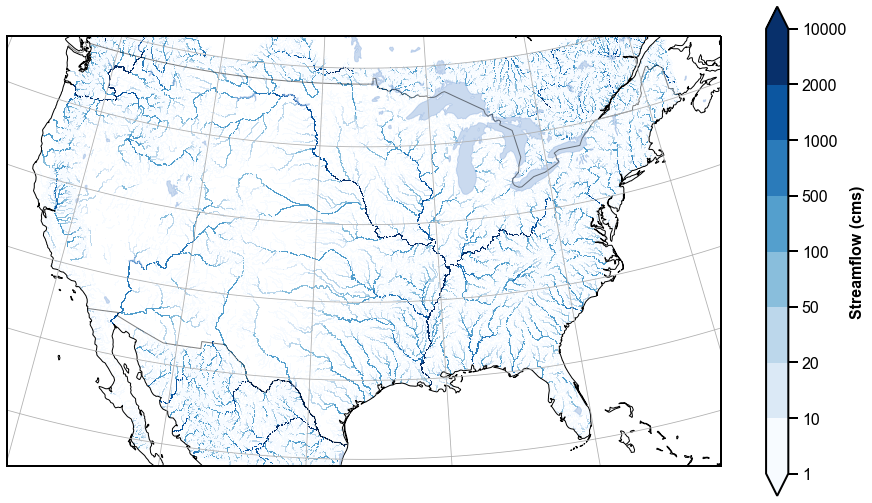

In [596]:
# src= flow_ctl.mean(axis=0)
# x= src.x
# y= src.y
# src= src.values.squeeze()
# src[src==-9999]=np.nan
# src[src<1]= np.nan
lccProjParams = { 'central_latitude'   : 50.0, # same as lat_0 in proj4 string 
                  'central_longitude'  : -96.0, # same as lon_0
                  'standard_parallels' : (33.0, 45.0) # same as (lat_1, lat_2)
}
proj = ccrs.LambertConformal(**lccProjParams)

fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(projection = proj)

cmap= plt.get_cmap('Blues')
bounds = [1,10,20,50,100,500,1000,2000,10000]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N) 
cs= ax.pcolormesh(x,y,src,norm=norm,cmap=cmap,transform=ccrs.PlateCarree())
cb=fig.colorbar(mappable=cs, extend='both')
cb.set_label('Streamflow (cms)')
ax.add_feature(feature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none'))
ax.add_feature(feature.NaturalEarthFeature(
        category='physical',
        name='lakes',
        scale='50m',
        facecolor='none'))
ax.coastlines('50m')
ax.add_feature(feature.LAKES, alpha=0.5)
ax.add_feature(feature.BORDERS, linestyle='-', alpha=.5)
ax.gridlines()
ax.set_extent([-120.0, -72.0, 22.0, 50.0]);

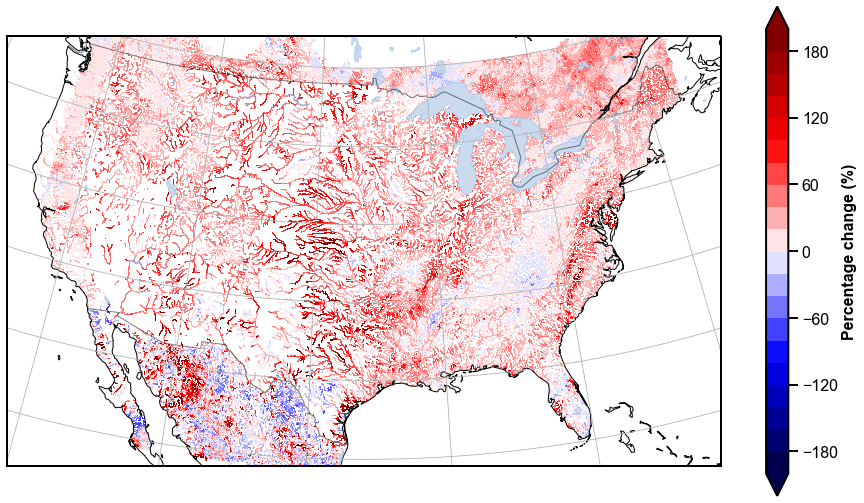

In [598]:
ctl= flow_ctl.mean(axis=0)
# x= src.x
# y= src.y
ctl= ctl.values.squeeze()
ctl[ctl<1]=np.nan
pgw=flow_pgw.mean(axis=0)
pgw= pgw.values.squeeze()
pgw[pgw<1]=np.nan

src= (pgw-ctl)/ctl*100

# src[src<1]= np.nan
lccProjParams = { 'central_latitude'   : 50.0, # same as lat_0 in proj4 string 
                  'central_longitude'  : -96.0, # same as lon_0
                  'standard_parallels' : (33.0, 45.0) # same as (lat_1, lat_2)
}
proj = ccrs.LambertConformal(**lccProjParams)

fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(projection = proj)

cmap= plt.get_cmap('seismic')
bounds = np.arange(-200,220,20)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N) 
cs= ax.pcolormesh(x,y,src,norm=norm,cmap=cmap,transform=ccrs.PlateCarree())
cb=fig.colorbar(mappable=cs, extend='both')
cb.set_label('Percentage change (%)')
ax.add_feature(feature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none'))
ax.add_feature(feature.NaturalEarthFeature(
        category='physical',
        name='lakes',
        scale='50m',
        facecolor='none'))
ax.coastlines('50m')
ax.add_feature(feature.LAKES, alpha=0.5)
ax.add_feature(feature.BORDERS, linestyle='-', alpha=.5)
ax.gridlines()
ax.set_extent([-120.0, -72.0, 22.0, 50.0]);

## Major rivers

In [702]:
obj= gpd.read_file('MajorRiver/Ohio_pnts.geojson')

In [703]:
coords= np.concatenate([np.array(pnt.coords) for pnt in obj.geometry])

In [704]:
x= xr.DataArray(coords[:,0], dims='z')
y= xr.DataArray(coords[:,1], dims='z')
ctl= flow_ctl.sel(x=x,y=y,method='nearest').values.squeeze()
pgw= flow_pgw.sel(x=x,y=y,method='nearest').values.squeeze()

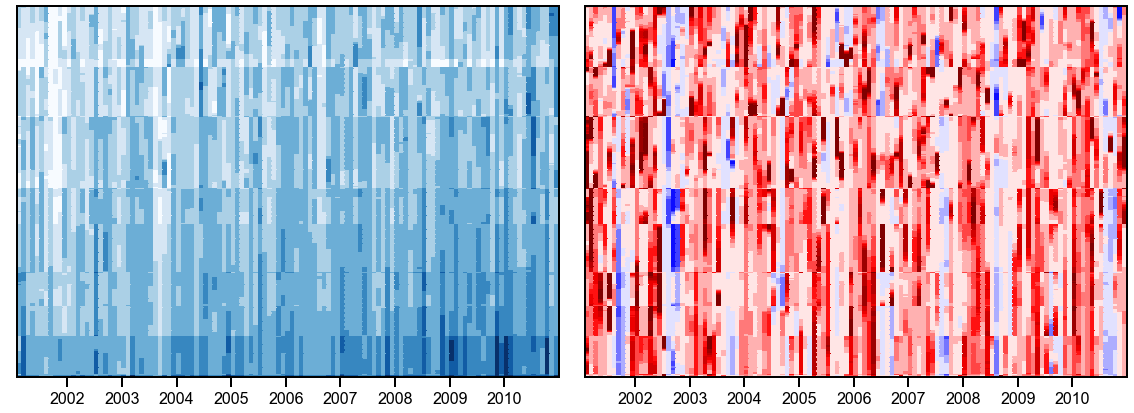

In [684]:
fig= plt.figure(figsize=(16,6))
ax= fig.add_subplot(121)
cmap= plt.get_cmap('Blues')
bounds = [100,500,1000,2000,5000,10000,20000,30000]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N) 
ax.pcolormesh( flow_ctl.Time,np.arange(ctl.shape[1]),ctl.T, cmap=cmap, norm=norm)
ax.invert_yaxis()
ax.set_yticks([]);
ax=fig.add_subplot(122)
cmap= plt.get_cmap('seismic')
bounds = np.arange(-200,220,20)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N) 
ax.pcolormesh(flow_ctl.Time,np.arange( ctl.shape[1]), ((pgw-ctl)/ctl*100).T, cmap=cmap, norm=norm)
# fmt_month = mdates.MonthLocator()
ax.invert_yaxis()
# ax.xaxis.set_minor_locator(fmt_month)
ax.set_yticks([]);

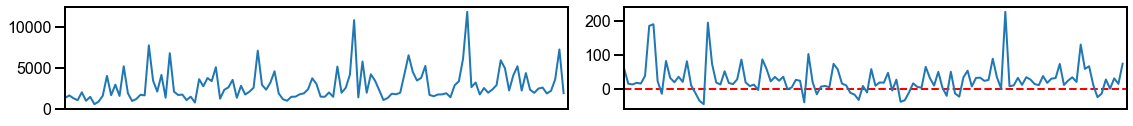

In [705]:
fig= plt.figure(figsize=(16,2))
ax= fig.add_subplot(121)
ax.plot(ctl.T.mean(axis=0))
ax.set_xlim([0,120])
ax.set_xticks([])
# ax.invert_yaxis()
# ax.set_yticks([]);
ax=fig.add_subplot(122)
ax.plot((((pgw-ctl)/ctl*100).T).mean(axis=0))
ax.hlines(0,0,len(ctl),'r', linestyle='--')
ax.set_xlim([0,120])
# fmt_month = mdates.MonthLocator()
# ax.invert_yaxis()
# ax.xaxis.set_minor_locator(fmt_month)
ax.set_xticks([]);

# Extract HUC8 basin

In [2]:
huc8_clip= gpd.read_file('HUC8_CONUS_clip/HUC8_CONUS')
huc8= gpd.read_file('HUC8_CONUS')
huc8= huc8[[True if name in huc8_clip.HUC8.values else False for name in huc8.HUC8]]

huc8.drop('colors',axis=1).to_file('HUC8_CONUS/HUC8_CONUS.shp')

In [58]:
# fac= xr.open_rasterio('/hydros/ZhiLi/EF5-US-Parameters-1.0.0/basic/facc_usa.tif')
dem= xr.open_rasterio('/hydros/ZhiLi/EF5-US-Parameters-1.0.0/basic/dem_usa.tif').rio.set_crs(4326)

In [4]:
def process(i):
    global huc8,fac
    geometry= huc8.iloc[i].geometry
    region= fac.rio.clip([geometry], drop=False)
    irow, icol= np.where(region.values.squeeze()==region.max().values)
    lon= fac.isel(band=0, x=icol[0], y=irow[0]).x.values
    lat= fac.isel(band=0, x=icol[0], y=irow[0]).y.values
    _fac= fac.isel(band=0, x=icol[0], y=irow[0]).values

    
    return i, irow[0], icol[0], lon, lat, _fac

with multiprocessing.Pool(36) as pool:
    results= pool.map(process, np.arange(len(huc8)))

In [ ]:
for (i, irow, icol, lon, lat, _fac) in results:
    huc8.loc[huc8.index[i], 'irow']= irow
    huc8.loc[huc8.index[i], 'icol']= icol
    huc8.loc[huc8.index[i], 'lon']= lon
    huc8.loc[huc8.index[i], 'lat']= lat
    huc8.loc[huc8.index[i], 'fac']= _fac

In [7]:
def task(fname):
    global irows, icols
    datetime= fname.split('.')[1]
    date= datetime.split('_')[0]
    time= datetime.split('_')[1]
    dt= pd.to_datetime('%s'%date+time, format='%Y%m%d%H%M')
    _ds= xr.open_rasterio(fname)
    data= np.diagonal(_ds.isel(x=icols, y=irows, band=0).values)

    del _ds
    return dt, data

In [8]:
irows= huc8.irow.values.astype(int)
icols= huc8.icol.values.astype(int)
basedir= '/media/scratch/ZhiLi/WRF_simu/reanalysis_correct'

geometry= huc8[np.isnan(huc8.icol)].geometry
i= huc8[np.isnan(huc8.lon)].index
region= fac.rio.clip([geometry[i[0]]], drop=False)
irow, icol= np.where(region.values.squeeze()==region.max().values)
huc8.loc[i, 'irow']= irow[0]
huc8.loc[i, 'icol']= icol[0]
huc8.loc[i, 'lon']= fac.isel(x=icol[0], y=irow[0]).x.values
huc8.loc[i, 'lat']= fac.isel(x=icol[0], y=irow[0]).y.values
# huc8[np.isnan(huc8.icol)].plot()

df_ctl= pd.DataFrame(columns=huc8.index, index=pd.date_range(start='20010101', end='20120101', freq='H'))
for date in pd.date_range(start='20010101', end='20110101', freq='M').strftime('%Y%m'):
    print(date)
    fnames= glob(basedir+'/q.%s*'%date)
    with multiprocessing.Pool(32) as pool:
        results= pool.map(task, fnames)
    datetimes= [datetime for (datetime, arr) in results]
    vals= [arr for (datetime, arr) in results]
    df_ctl.loc[datetimes, :]= vals
    del results, fnames

basedir= '/media/scratch/ZhiLi/WRF_simu/future_correct'
df_pgw= pd.DataFrame(columns=huc8.index, index=pd.date_range(start='20010101', end='20120101', freq='H'))
for date in pd.date_range(start='20010101', end='20120101', freq='M').strftime('%Y%m'):
    print(date)
    fnames= glob(basedir+'/q.%s*'%date)
    with multiprocessing.Pool(36) as pool:
        results= pool.map(task, fnames)
    datetimes= [datetime for (datetime, arr) in results]
    vals= [arr for (datetime, arr) in results]
    df_pgw.loc[datetimes, :]= vals
    del results, fnames

basedir= '/media/scratch/ZhiLi/WRF_simu/crest/reference'
df_ref= pd.DataFrame(columns=huc8.index, index=pd.date_range(start='20020101', end='20130101', freq='H'))
for date in pd.date_range(start='20020101', end='20130101', freq='M').strftime('%Y%m'):
    print(date)
    fnames= glob(basedir+'/q.%s*'%date)
    with multiprocessing.Pool(36) as pool:
        results= pool.map(task, fnames)
    datetimes= [datetime for (datetime, arr) in results]
    vals= [arr[0] for (datetime, arr) in results]
    df_ref.loc[datetimes, :]= vals
    del results, fnames

In [351]:
states= states[states.name!='Commonwealth of the Northern Mariana Islands']

huc8= huc8[[True if name not in ['Rio Conchos', 'Rio Salado', 'Rio San Juan',
                                'Rio De La Concepcion', 'Playas Lake'] else False for name in huc8.NAME]]

In [334]:
states= gpd.read_file('../GPM_DPR/US_floods_states')

In [6]:
flow_sig= xr.open_dataset('GSCD/GSCD_v2.0.nc')
flow_sig= flow_sig.sel(longitude=slice(-125,-60), latitude=slice(55,22))

In [8]:
sample= [flow_sig.QMEAN.rio.set_crs('EPSG:4326').rio.clip(huc8.iloc[[i]].geometry,
                        all_touched=True, drop=False) for i in range(len(huc8))]

In [92]:
df_ctl= pd.read_csv('GSCD/flow.ctl.csv', index_col=[0], converters={'datetime': pd.to_datetime})
df_pgw= pd.read_csv('GSCD/flow.pgw.csv', index_col=[0], converters={'datetime': pd.to_datetime})
df_ref= pd.read_csv('GSCD/flow.ref.csv', index_col=[0], converters={'datetime': pd.to_datetime})

df_ctl[df_ctl<0]= np.nan
df_pgw[df_pgw<0]= np.nan
df_ref[df_ref<0]= np.nan

df_ctl.index= pd.to_datetime(df_ctl.index)
df_pgw.index= pd.to_datetime(df_pgw.index)
df_ref.index= pd.to_datetime(df_ref.index)

In [10]:
annual_runoff= [df_ctl.iloc[:,i].sum()/huc8.loc[i,'fac']/1e6*3600/len(df_ctl)*24*365 for i in range(len(huc8))]
huc8['arunoff_ctl']= annual_runoff

annual_runoff= [df_pgw.iloc[:,i].sum()/huc8.loc[i,'fac']/1e6*3600/len(df_pgw)*24*365 for i in range(len(huc8))]
huc8['arunoff_pgw']= annual_runoff

annual_runoff= [df_ref.iloc[:,i].sum()/huc8.loc[i,'fac']/1e6*3600/len(df_ref)*24*365 for i in range(len(huc8))]
huc8['arunoff_ref']= annual_runoff

annual_runoff= [flow_sig.QMEAN.where(~np.isnan(sample[i]),drop=True).mean().values for i in range(len(huc8))]
huc8['arunoff_gv']= annual_runoff

huc8.arunoff_gv= huc8.arunoff_gv.astype(float)

In [523]:
runoff= [(df_ctl.iloc[:,i].dropna()/huc8.loc[i,'fac']*3.6).resample('D').sum().resample('Y').quantile(0.90).max() for i in huc8.index]
huc8['q90_ctl']= runoff

runoff= [(df_pgw.iloc[:,i].dropna()/huc8.loc[i,'fac']*3.6).resample('D').sum().resample('Y').quantile(0.90).max() for i in huc8.index]
huc8['q90_pgw']= runoff

runoff= [(df_ref.iloc[:,i].dropna()/huc8.loc[i,'fac']*3.6).resample('D').sum().resample('Y').quantile(0.90).max() for i in huc8.index]
huc8['q90_ref']= runoff

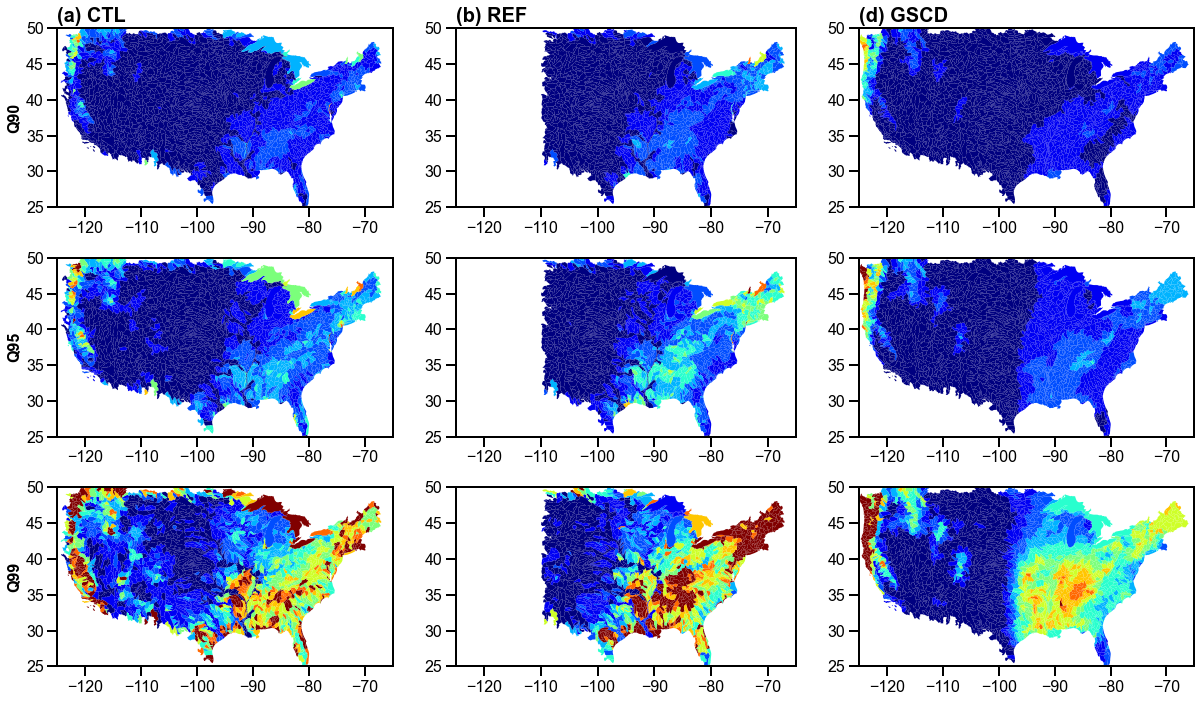

In [524]:
fig= plt.figure(constrained_layout=True, figsize=(18,10))
bounds= np.arange(0,22,2)
cmap= plt.get_cmap('jet',len(bounds-1))
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N) 
cols= ['q90','q95','q99']
for i in range(3):
    col= cols[i]+'_ctl'
    ax=fig.add_subplot(3,3,3*i+1)
    huc8[~(huc8[col]==0)].plot(column=huc8[~(huc8[col]==0)][col], ax=ax, cmap=cmap, norm=norm)
    if i==0:
        ax.set_title('(a) CTL', weight='bold', loc='left')
    ax.set_xlim([-125,-65])
    ax.set_ylim([25,50]);
    if i==0: ax.set_ylabel('Q90')
    elif i==1: ax.set_ylabel('Q95')
    else: ax.set_ylabel('Q99')
    
    # ax=fig.add_subplot(132)
    # huc8[~(huc8.q90_pgw==0)].plot(column=huc8.q90_pgw[~(huc8.q90_pgw==0)], ax=ax, cmap=cmap, norm=norm)
    # # states.plot(ax=ax,color='None',edgecolor='k')
    # ax.set_title('(b) PGW', weight='bold', loc='left')
    # ax.set_xlim([-125,-65])
    # ax.set_ylim([25,50]);
    ax=fig.add_subplot(3,3,3*i+2)
    col= cols[i]+'_ref'
    huc8[~huc8.west110].plot(column=huc8[col][~huc8.west110], ax=ax, cmap=cmap, norm=norm)
    # states.plot(ax=ax,color='None',edgecolor='k')
    if i==0:ax.set_title('(b) REF', weight='bold', loc='left')
    ax.set_xlim([-125,-65])
    ax.set_ylim([25,50]);
    ax=fig.add_subplot(3,3,3*i+3)
    col= cols[i]+'_gv'
    huc8.plot(column=huc8[col], ax=ax, cmap=cmap, norm=norm)
    # states.plot(ax=ax,color='None',edgecolor='k')
    if i==0:ax.set_title('(d) GSCD', weight='bold', loc='left')
    ax.set_xlim([-125,-65])
    ax.set_ylim([25,50]);
plt.show();
# cax = fig.add_axes([0.2, 0.001, 0.6, 0.03])
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# # fake up the array of the scalar mappable. Urgh...
# sm._A = []
# cb=fig.colorbar(sm, cax=cax, orientation='horizontal', extend='both', ticks=np.arange(0,22,2))
# cb.set_label('runoff (mm/day)');

In [281]:
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size

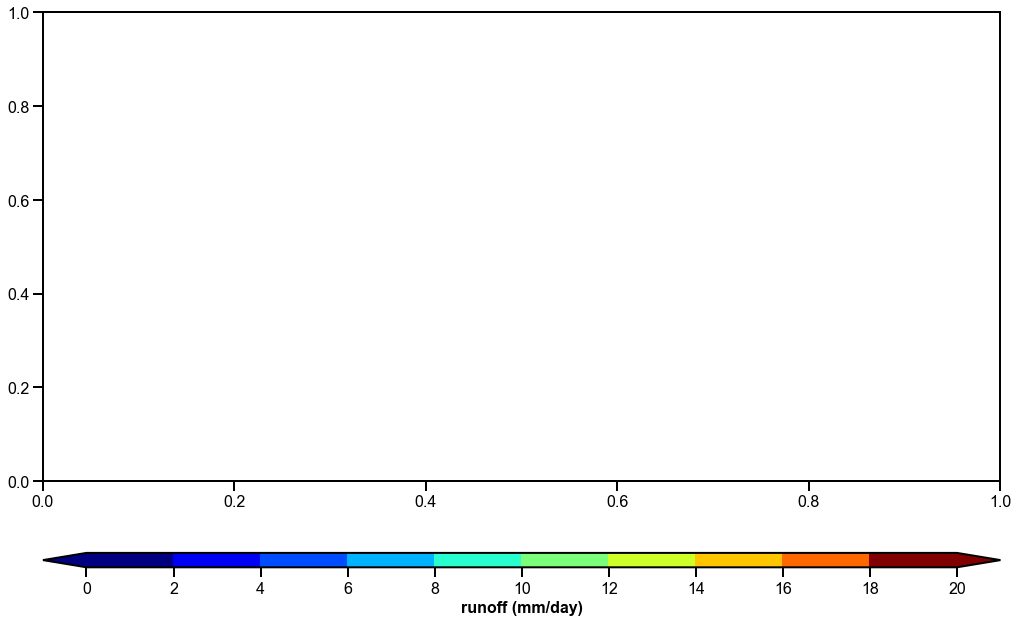

In [288]:
ax = plt.gca()
divider = make_axes_locatable(ax)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# fake up the array of the scalar mappable. Urgh...
sm._A = []
cax = divider.append_axes("bottom", size=0.2, pad=1)
cb=plt.colorbar(sm, orientation='horizontal', cax=cax, extend='both', ticks=np.arange(0,22,2))
cb.set_label('runoff (mm/day)');

In [29]:
fig.savefig('GSCD/figs/Q99_all.png')

In [6]:
import seaborn as sns
from scipy import stats
from shapely.geometry import Polygon

In [7]:
def cal_stats(x,y):
    bias= (x.sum()-y.sum())/y.sum()
    rmse= ((x-y)**2).mean()**0.5
    return bias, rmse

In [8]:
west110= gpd.GeoDataFrame(geometry=gpd.GeoSeries(Polygon([(-125,25), (-125,50), (-110,50), (-110,25)])))
canvas= huc8 - west110

In [9]:
for i in huc8.index:
    if type(huc8.geometry[i]) is Polygon:
        if (np.array(huc8.geometry[i].exterior.coords)[:,0]<-110).any():
            huc8.loc[i,'west110']=True
        else:
            huc8.loc[i,'west110']=False
    else:
        geom= np.concatenate([list(poly.exterior.coords) for poly in list(huc8.geometry[i])])
        if (geom<-110).any():
            huc8.loc[i,'west110']=True
        else:
            huc8.loc[i,'west110']=False

huc8.to_file('HUC8_CONUS/HUC8_CONUS.shp')

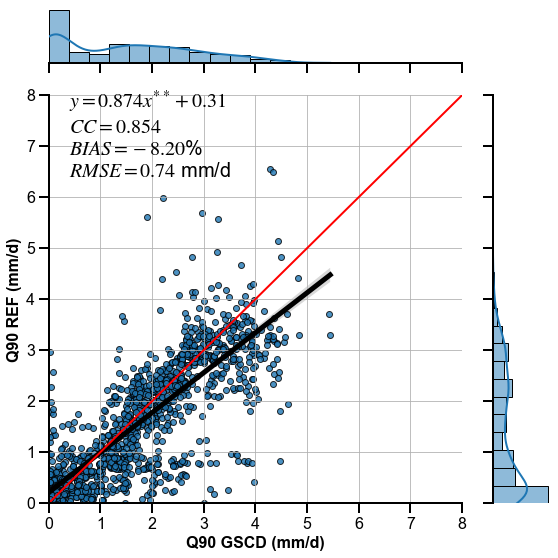

In [22]:
est= 'q90_ref'
ref= 'q90_gv'
bias, rmse= cal_stats(huc8[~huc8.west110][~pd.isna(huc8.q99_ref)][est].values,
                      huc8[~huc8.west110][~pd.isna(huc8.q99_ref)][ref].values)
slope, intercept, r_value, p_value, std_err = stats.linregress(\
                                                    huc8[~huc8.west110][~pd.isna(huc8.q99_ref)][est].values,
                                                    huc8[~huc8.west110][~pd.isna(huc8.q99_ref)][ref].values)
g=sns.jointplot(x=ref,y=est,data=huc8[~huc8.west110],
                kind='reg', height=8, scatter_kws={'edgecolor':'k'},
               joint_kws={'line_kws': {'linewidth': 5, 'color':'k'}},)
r_value= stats.spearmanr(huc8[~huc8.west110][~pd.isna(huc8.q99_ref)][est],
                         huc8[~huc8.west110][~pd.isna(huc8.q99_ref)][ref])[0]
g.ax_joint.text(0.05,0.8,'$y=%.3fx^{**}+%.2f$\n$CC=%.3f$\n$BIAS=%.2f$%%\n$RMSE=%.2f$ mm/d'%(slope,
                    intercept,r_value, bias*100, rmse), transform=g.ax_joint.transAxes,fontsize=20)
g.ax_joint.plot([0,25],[0,25],color='r')
g.ax_joint.set_xlim([0,8])
g.ax_joint.set_ylim([0,8])
g.ax_joint.set_xlabel('Q90 GSCD (mm/d)')
g.ax_joint.set_ylabel('Q90 REF (mm/d)')
g.ax_joint.grid();

In [239]:
g.savefig('GSCD/figs/Q90_GSCD_ref.png')

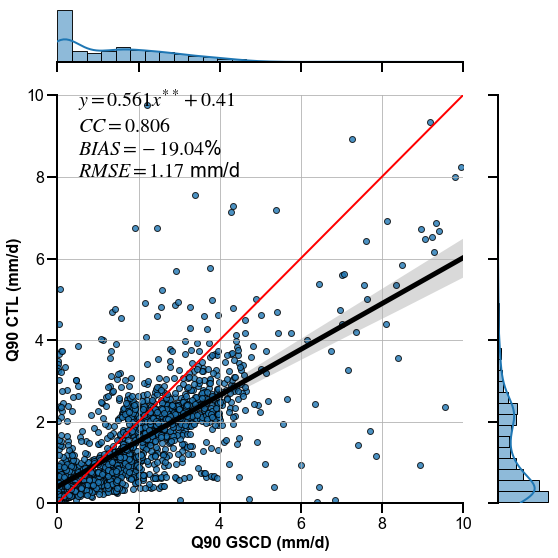

In [23]:
est= 'q90_ctl'
ref= 'q90_gv'
bias, rmse= cal_stats(huc8[~pd.isna(huc8[est]) & (huc8[est]>0)][est].values,
                      huc8[~pd.isna(huc8[est]) & (huc8[est]>0)][ref].values)
slope, intercept, r_value, p_value, std_err = stats.linregress(huc8[~pd.isna(huc8[est]) & (huc8[est]>0)][ref],
                                                               huc8[~pd.isna(huc8[est]) & (huc8[est]>0)][est])

g=sns.jointplot(x=ref,y=est,data=huc8[~pd.isna(huc8[est]) & (huc8[est]>0)],
                kind='reg', height=8, scatter_kws={'edgecolor':'k'},
               joint_kws={'line_kws': {'linewidth': 5, 'color':'k'}})
r_value= stats.spearmanr(huc8[~pd.isna(huc8[est]) & (huc8[est]>0)][ref],
                        huc8[~pd.isna(huc8[est]) & (huc8[est]>0)][est])[0]
g.ax_joint.text(0.05,0.8,'$y=%.3fx^{**}+%.2f$\n$CC=%.3f$\n$BIAS=%.2f$%%\n$RMSE=%.2f$ mm/d'%(slope,intercept,r_value, bias*100, rmse), transform=g.ax_joint.transAxes,fontsize=20)
g.ax_joint.plot([0,35],[0,35],color='r')
g.ax_joint.set_xlim([0,10])
g.ax_joint.set_ylim([0,10])
g.ax_joint.set_xlabel('Q90 GSCD (mm/d)')
g.ax_joint.set_ylabel('Q90 CTL (mm/d)')
g.ax_joint.grid();

In [256]:
g.savefig('GSCD/figs/Q99_GSCD_ctl.png')

# Flashiness

In [93]:
rain_ctl= pd.read_csv('GSCD/rain.ctl.csv', index_col=[0])
rain_ctl.index= pd.to_datetime(rain_ctl.index)
rain_pgw= pd.read_csv('GSCD/rain.pgw.csv', index_col=[0])
rain_pgw.index= pd.to_datetime(df_pgw.index)

In [47]:
from scipy import io

In [10]:
ctl_mat= io.loadmat('GSCD/ctl/Results1.mat')
pgw_mat= io.loadmat('GSCD/pgw/Results1.mat')

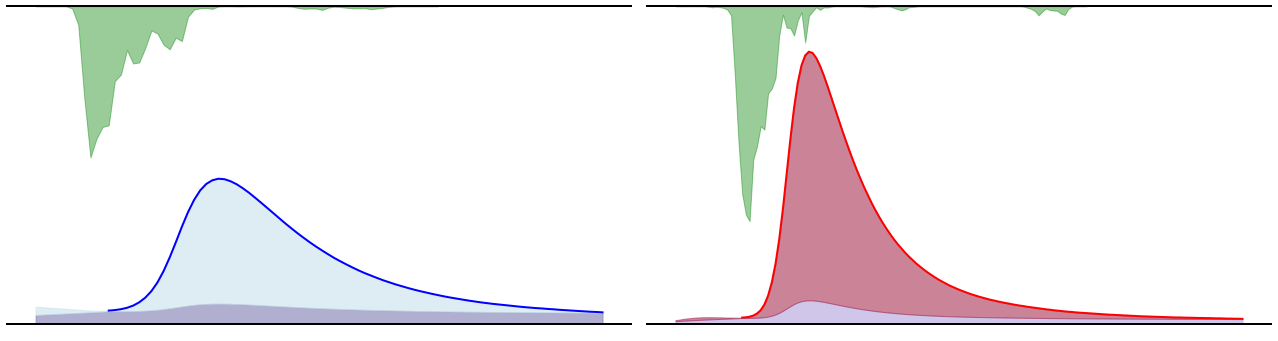

In [202]:
fig=plt.figure(figsize=(18,5))
ax= fig.add_subplot(121)
ax.plot(df_ctl['0'].iloc[644:726], color='b')

# df_ctl['0'].iloc[644:726].plot(ax=ax)
# df_pgw['0'].iloc[641:777].plot(ax=ax)


ax.fill_between(df_ctl['0'].iloc[632:726].index, 0, (ctl_mat['Qbf'][632:726]*huc8.iloc[0].AREASQKM/3.6).reshape(-1),  color='#7C7BB2', alpha=0.6)
ax.fill_between(df_ctl['0'].iloc[632:726].index, (ctl_mat['Q'][632:726]*huc8.iloc[0].AREASQKM/3.6).reshape(-1),
                                                (ctl_mat['Qbf'][632:726]*huc8.iloc[0].AREASQKM/3.6).reshape(-1),  color='#C8E2EB', alpha=0.6)
# ax.axis('on')
# ax.set_ylabel('Q (cms)')
# ax.set_xticklabels(ax.get_xticklabels(), rotation=15)
ax.set_xticks([])
ax.set_yticks([])
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.xaxis('off')
ax.set_ylim([0,250])
ax2= ax.twinx()
ax2.fill_between(rain_ctl['0'].iloc[632:699].index, 0, rain_ctl['0'].iloc[632:699], color='green', alpha=0.4)
ax2.invert_yaxis()
ax2.set_ylim([3,0])
# ax2.set_ylabel('R (mm/h)')
ax2.set_xticks([]);
ax2.set_yticks([]);
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)

ax= fig.add_subplot(122)
ax.plot(df_pgw['0'].iloc[641:777],color='r')
ax.fill_between(df_pgw['0'].iloc[623:777].index, 0, (pgw_mat['Qbf'][623:777]*huc8.iloc[0].AREASQKM/3.6).reshape(-1),  color='#B1A0DB', alpha=0.6)
ax.fill_between(df_pgw['0'].iloc[623:777].index, (pgw_mat['Q'][623:777]*huc8.iloc[0].AREASQKM/3.6).reshape(-1),
                                                (pgw_mat['Qbf'][623:777]*huc8.iloc[0].AREASQKM/3.6).reshape(-1),  color='#A93154', alpha=0.6)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=15)
ax.set_ylim([0,250])

ax.spines['left'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.set_ylabel('Q (cms)')
ax2= ax.twinx()
ax2.fill_between(rain_pgw['0'].iloc[623:735].index, 0, rain_pgw['0'].iloc[623:735], color='green', alpha=0.4)
ax2.invert_yaxis()
ax2.set_ylim([3,0])
# ax2.set_ylabel('R (mm/h)')
ax2.set_xticks([])
ax2.set_yticks([])
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False);

In [5]:
from statsmodels.distributions.empirical_distribution import ECDF

In [50]:
flashiness_ctl= []
flashiness_pgw= []
# for col in huc8_clip.index:
for col in [93]:
    if os.path.exists('GSCD/ctl/Results%d.mat'%(int(col)+1)) and os.path.exists('GSCD/pgw/Results%d.mat'%(int(col)+1)):
#         print(col)
        ctl= io.loadmat('GSCD/ctl/Results%d.mat'%(int(col)+1))
        pgw= io.loadmat('GSCD/pgw/Results%d.mat'%(int(col)+1))
        huc8_clip.loc[col,'num_events_ctl']= len(ctl['RFE']['tE'][0,0])
        huc8_clip.loc[col,'num_events_pgw']= len(pgw['RFE']['tE'][0,0])
        Tp_ctl= ctl['RFE']['tE'][0,0][:,-1].astype(int)
        Ts_ctl= ctl['RFE']['tE'][0,0][:,1].astype(int)
        Qp_ctl= ctl['Q'][Tp_ctl] - ctl['Qbf'][Tp_ctl]
        _flashiness_ctl= Qp_ctl.reshape(-1)/(Tp_ctl-Ts_ctl)
        Tp_pgw= pgw['RFE']['tE'][0,0][:,-1].astype(int)
        Ts_pgw= pgw['RFE']['tE'][0,0][:,1].astype(int)
        Qp_pgw= pgw['Q'][Tp_pgw] - pgw['Qbf'][Tp_pgw]
        _flashiness_pgw= Qp_pgw.reshape(-1)//(Tp_pgw-Ts_pgw)
        Trs_ctl= ctl['RFE']['tE'][0,0][:,0]
        Tre_ctl= ctl['RFE']['tE'][0,0][:,2]
        Trs_pgw= pgw['RFE']['tE'][0,0][:,0]
        Tre_pgw= pgw['RFE']['tE'][0,0][:,2]
        P_ctl = ctl['P']
        P_pgw= pgw['P']        
        huc8_clip.loc[col, 'Rp_ctl']= np.nanquantile([np.nanmax(P_ctl[int(s):int(e)]) for (s,e) in zip(Trs_ctl, Tre_ctl)],0.99)
        huc8_clip.loc[col, 'Rp_pgw']= np.nanquantile([np.nanmax(P_pgw[int(s):int(e)]) for (s,e) in zip(Trs_pgw, Tre_pgw)],0.99)        
#         flashiness= np.concatenate([flashiness_ctl.reshape(-1), flashiness_pgw.reshape(-1)])

        if len(_flashiness_ctl)>0:
            flashiness_ctl.append(_flashiness_ctl)
            flashiness_pgw.append(_flashiness_pgw)
#             dist= ECDF(flashiness)
#             huc8.loc[col,'flashiness_ctl']= dist(flashiness_ctl).mean()
#             huc8.loc[col,'flashiness_pgw']= dist(flashiness_pgw).mean()
#             flashiness_idx.append(int(col))
        else:
#             huc8.loc[col,'flashiness_ctl']= np.nan
#             huc8.loc[col,'flashiness_pgw']= np.nan
            pass
#         huc8['T_ctl']= len(ctl['RFE']['tE'][0,0])

/home/ZhiLi/env/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1366: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [51]:
flashiness= np.concatenate([np.concatenate(flashiness_ctl), np.concatenate(flashiness_pgw)])
dist= ECDF(flashiness)

ValueError: need at least one array to concatenate

In [56]:
huc8= huc8.drop_duplicates('TNMID')

In [60]:
huc8.index.

Int64Index([   0,    1,    2,    3,    4,    6,    9,   11,   14,   15,
            ...
            2678, 2680, 2682, 2684, 2685, 2687, 2688, 2690, 2692, 2694],
           dtype='int64', length=2125)

In [57]:
# char_climate = 
for col in huc8.index.tolist():
    if os.path.exists('GSCD/ctl/Results%d.mat'%(int(col)+1)) and os.path.exists('GSCD/pgw/Results%d.mat'%(int(col)+1)):
        ctl= io.loadmat('GSCD/ctl/Results%d.mat'%(int(col)+1))
        pgw= io.loadmat('GSCD/pgw/Results%d.mat'%(int(col)+1))
        huc8.loc[col,'num_events_ctl']= len(ctl['RFE']['tE'][0,0])
        huc8.loc[col,'num_events_pgw']= len(pgw['RFE']['tE'][0,0])
        Tp_ctl= ctl['RFE']['tE'][0,0][:,-1].astype(int)
        Ts_ctl= ctl['RFE']['tE'][0,0][:,1].astype(int)
        Trs_ctl= ctl['RFE']['tE'][0,0][:,0]
        Tre_ctl= ctl['RFE']['tE'][0,0][:,2]
        P_ctl= ctl['P']
        Qp_ctl= ctl['Q'][Tp_ctl] - ctl['Qbf'][Tp_ctl]
        _flashiness_ctl= Qp_ctl.reshape(-1)/(Tp_ctl-Ts_ctl)
        Tp_pgw= pgw['RFE']['tE'][0,0][:,-1].astype(int)
        Ts_pgw= pgw['RFE']['tE'][0,0][:,1].astype(int)
        Trs_pgw= pgw['RFE']['tE'][0,0][:,0]
        Tre_pgw= pgw['RFE']['tE'][0,0][:,2]
        Qp_pgw= pgw['Q'][Tp_pgw] - pgw['Qbf'][Tp_pgw]
        P_pgw= pgw['P']
        _flashiness_pgw= Qp_pgw.reshape(-1)/(Tp_pgw-Ts_pgw)
        huc8.loc[col, 'Vr_ctl']= np.nanquantile([np.nansum(P_ctl[int(start):int(end)]) for (start, end) in zip(Trs_ctl, Tre_ctl)],.99)
        huc8.loc[col, 'Vr_pgw']= np.nanquantile([np.nansum(P_pgw[int(start):int(end)]) for (start, end) in zip(Trs_pgw, Tre_pgw)],.99)
#         huc8.loc[col,'lag_ctl']= ctl['RFE']['tE']
#         if len(_flashiness_ctl)>0:
#             huc8.loc[col,'flashiness_ctl']= dist(_flashiness_ctl).mean()
#             huc8.loc[col,'flashiness_pgw']= dist(_flashiness_pgw).mean()
#         else:
#             huc8.loc[col,'flashiness_ctl']= np.nan
#             huc8.loc[col,'flashiness_pgw']= np.nan
#             pass

/home/ZhiLi/env/lib/python3.6/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


# Extreme rainfall changes

In [27]:
from geocube.api.core import make_geocube
from shapely.geometry import Polygon

In [41]:
x= np.arange(-125,-65,2.5)
y= np.arange(22, 50,2.5)
x,y= np.meshgrid(x,y)

In [45]:
collection= plt.hexbin(x,y,gridsize=25, edgecolor='black')
plt.close()
hex_polys = collection.get_paths()[0].vertices
hex_array = []
for xs,ys in collection.get_offsets():
    hex_x = np.add(hex_polys[:,0],  xs)
    hex_y = np.add(hex_polys[:,1],  ys)
    hex_array.append(Polygon(np.vstack([hex_x, hex_y]).T))

hex_grid = gpd.GeoDataFrame({'geometry':hex_array}).set_crs(4326)

In [33]:
huc8= gpd.GeoDataFrame(huc8, geometry=huc8.geometry)

In [58]:
hex_grid= gpd.sjoin(hex_grid, huc8[['Vr_ctl', 'Vr_pgw', 'geometry']], how='left', op='intersects')

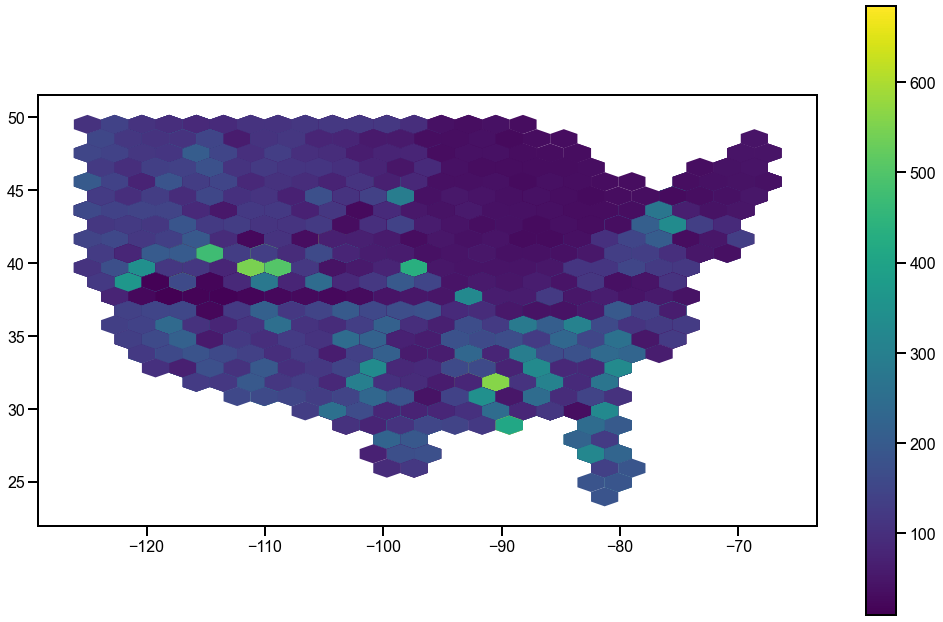

In [59]:
hex_grid.plot('Vr_ctl', legend=True)

In [5]:
cube = make_geocube(
    huc8,
    measurements=["Vr_ctl", "Vr_pgw"],
    resolution=(1, -1),
#     interpolate_na_method='cubic'
)

In [9]:
whole_region= climate_zone.dissolve('DN')

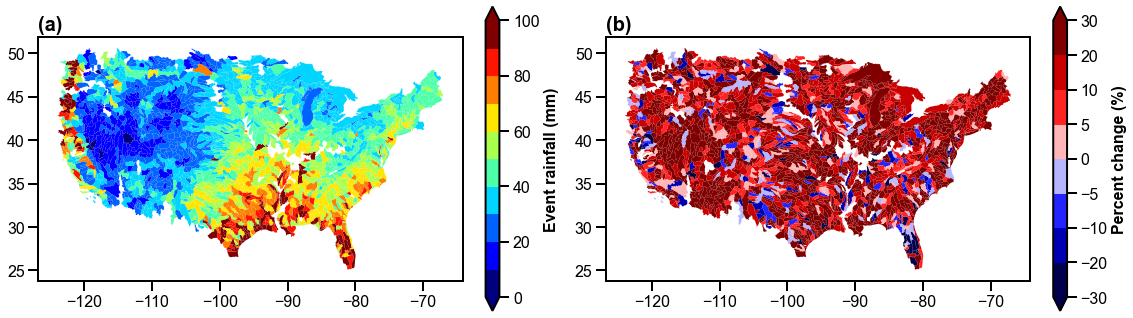

In [444]:
fig= plt.figure(figsize=(16,6))
ax=fig.add_subplot(121, projection=proj)
bounds= np.arange(0,110,10)
cmap= plt.get_cmap('jet',len(bounds)-1)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
huc8[~(huc8.q95_ctl==0)].plot(column='Vr_ctl',ax=ax, cmap=cmap, norm=norm, legend=True,
                             legend_kwds={'fraction':0.03,'extend':'both', 'label':'Event rainfall (mm)'})
ax.set_title('(a)', weight='bold', loc='left')
ax= fig.add_subplot(122)
bounds= np.array([-30,-20,-10,-5,0,5,10,20,30])
cmap= plt.get_cmap('seismic',len(bounds)-1)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
huc8[~(huc8.q95_ctl==0)].plot(column=(huc8[~(huc8.q95_ctl==0)].Vr_pgw-
                              huc8[~(huc8.q95_ctl==0)].Vr_ctl)/huc8[~(huc8.q95_ctl==0)].Vr_ctl*100, ax=ax, cmap=cmap, norm=norm,legend=True,
                             legend_kwds={'fraction':0.03,'extend':'both', 'label':'Percent change (%)'})
ax.set_title('(b)', weight='bold', loc='left');

Text(0.5, 0, 'Flashiness index')

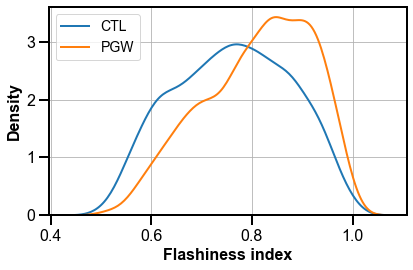

In [311]:
fig= plt.figure(figsize=(6,4))
ax= fig.add_subplot(111)
sns.kdeplot(huc8.flashiness_ctl,ax=ax,label='CTL')
sns.kdeplot(huc8.flashiness_pgw,ax=ax,label='PGW')
ax.legend()
ax.set_xlabel('Flashiness index')
ax.grid()

In [68]:
lccProjParams = { 'central_latitude'   : 50.0, # same as lat_0 in proj4 string 
                  'central_longitude'  : -96.0, # same as lon_0
                  'standard_parallels' : (33.0, 45.0) # same as (lat_1, lat_2)
}
proj = ccrs.LambertConformal(**lccProjParams)

In [75]:
import cartopy.crs as ccrs
from cartopy import feature

In [92]:
climate_zone['label']= climate_zone.Region.map(encode)
huc8['colors']= huc8.Region.map(dict_colors)

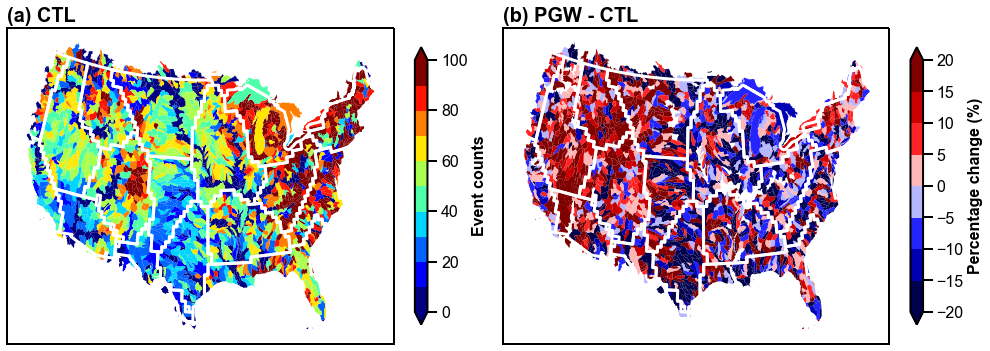

In [87]:
fig= plt.figure(figsize=(14,8))
ax=fig.add_subplot(121, projection=proj)
bounds= np.arange(0,110,10)
cmap= plt.get_cmap('jet',len(bounds)-1)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
huc8[~(huc8.q95_ctl==0)].plot(column='num_even_2',ax=ax, cmap=cmap, norm=norm, legend=True,
                             legend_kwds={'fraction':0.03,'extend':'both', 'label':'Event counts'}, transform=ccrs.PlateCarree())
ax.set_title('(a) CTL', weight='bold', loc='left')
ax.add_feature(feature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none'))
ax.add_feature(feature.NaturalEarthFeature(
        category='physical',
        name='lakes',
        scale='50m',
        facecolor='none'))
climate_zone.plot(color='None', edgecolor='white', ax=ax, transform=ccrs.PlateCarree(), linewidth=3);
for idx, row in climate_zone.iterrows():
    if row['label'] in ['f','g','i','j','k','l','m','n','o','p','q']:
        geom=np.array(row.geometry.centroid.coords).squeeze()
        ax.text(geom[0],geom[1],'%s'%(row['label']), color='white', weight='bold', fontsize=30);

ax= fig.add_subplot(122,projection=proj)
bounds= np.arange(-20,25,5)
cmap= plt.get_cmap('seismic',len(bounds)-1)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
huc8[~(huc8.q95_ctl==0)].plot(column=((huc8[~(huc8.q95_ctl==0)].num_even_3-
                              huc8[~(huc8.q95_ctl==0)].num_even_2)/(huc8[~(huc8.q95_ctl==0)].num_even_2))*100, ax=ax, cmap=cmap, norm=norm,legend=True,
                              legend_kwds={'fraction':0.03,'extend':'both', 'label':'Percentage change (%)'}, transform=ccrs.PlateCarree())
ax.set_title('(b) PGW - CTL', weight='bold', loc='left')
ax.add_feature(feature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none'))
ax.add_feature(feature.NaturalEarthFeature(
        category='physical',
        name='lakes',
        scale='50m',
        facecolor='none'))
climate_zone.plot(color='None', edgecolor='white', ax=ax, transform=ccrs.PlateCarree(), linewidth=3);
for idx, row in climate_zone.iterrows():
    if row['label'] in ['f','g','i','j','k','l','m','n','o','p','q']:
        geom=np.array(row.geometry.centroid.coords).squeeze()
        ax.text(geom[0],geom[1],'%s'%(row['label']), color='white', weight='bold', fontsize=30);
plt.show();

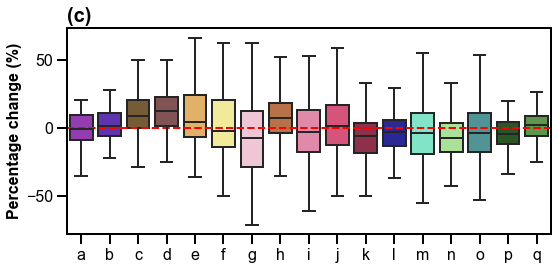

In [100]:
orders= ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q']
fig= plt.figure(figsize=(8,4))
ax= fig.add_subplot(111)
ax= sns.boxplot(x=huc8.Region.map(encode), y=(huc8.num_even_3-huc8.num_even_2)/huc8.num_even_2*100,notch=False,
                showfliers=False,ax=ax,order=orders,
                palette=[huc8[huc8.Region.map(encode)==o].colors.values[0] for o in orders])
ax.hlines(0,-0.5,17, color='r', linestyle='dashed')
ax.set_xlim([-0.5,16.5])
ax.set_title('(c)', weight='bold', loc='left')
ax.set_xlabel('')
ax.set_ylabel('Percentage change (%)');
# ticks= ax.get_xticks()
# ax.set_xticks(ticks);
# ax.set_xticklabels(['']);

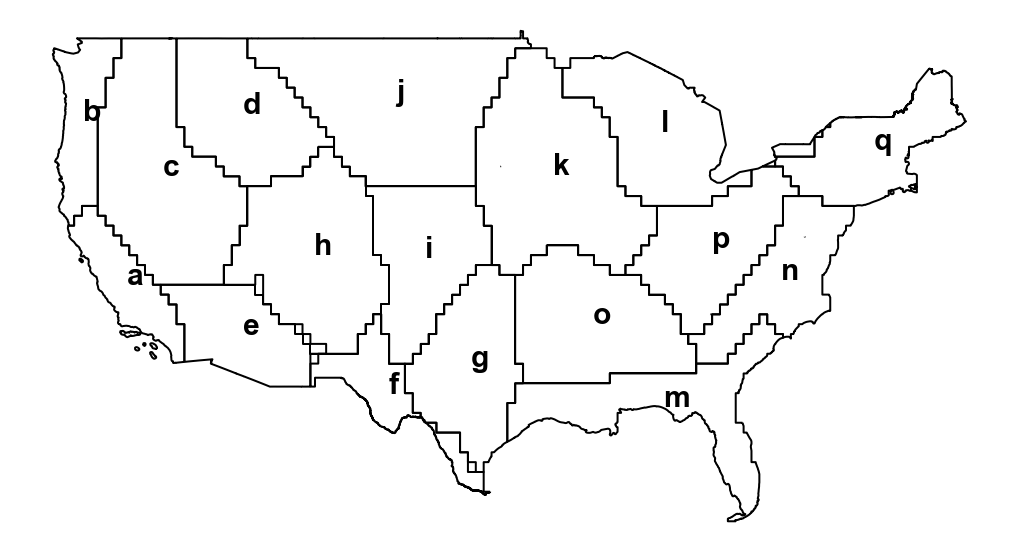

In [102]:
fig=plt.figure()
ax=fig.add_subplot(111)
# cmap= matplotlib.colors.ListedColormap(huc8[~pd.isna(huc8.Region)].colors)
climate_zone.plot(ax=ax, color='None', edgecolor='k', linewidth=2)
ax.axis('off');
ax.set_xticks([])
ax.set_yticks([])
for idx, row in climate_zone.iterrows():
#     if row['label'] in ['f','g','i','j','k','l','m','n','o','p','q']:
    geom=np.array(row.geometry.centroid.coords).squeeze()
    ax.text(geom[0],geom[1],'%s'%(row['label']), color='k', weight='bold', fontsize=30);
# ax.set_xlim([-105,-65])
plt.show();

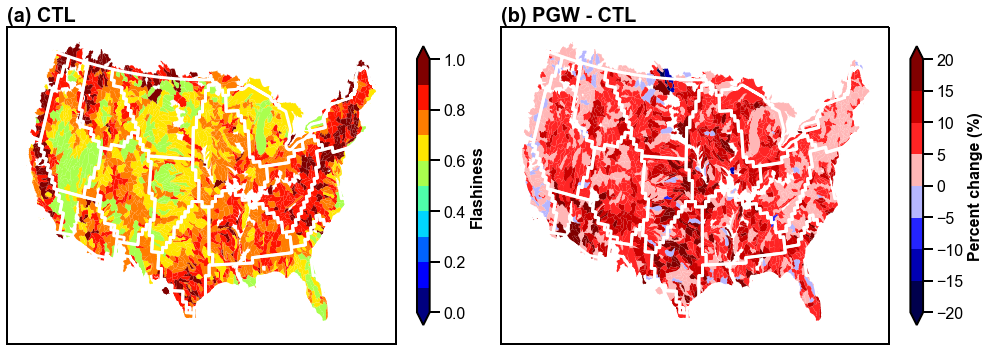

In [105]:
fig= plt.figure(figsize=(14,8))
ax=fig.add_subplot(121,projection=proj)
bounds= np.arange(0,1.1,0.1)
cmap= plt.get_cmap('jet',len(bounds)-1)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
huc8.plot(column=huc8.flashine_2,ax=ax, cmap=cmap, norm=norm, legend=True,
         legend_kwds={'fraction':0.03,'extend':'both', 'label':'Flashiness'}, transform=ccrs.PlateCarree())
ax.set_title('(a) CTL', weight='bold', loc='left')
climate_zone.plot(color='None', edgecolor='white', ax=ax, transform=ccrs.PlateCarree(), linewidth=3);

ax= fig.add_subplot(122, projection=proj)
bounds= np.arange(-20,25,5)
cmap= plt.get_cmap('seismic',len(bounds)-1)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
huc8.plot(column=(huc8.flashine_3-huc8.flashine_2)/huc8.flashine_2*100, ax=ax, cmap=cmap, norm=norm,legend=True,
         legend_kwds={'fraction':0.03,'extend':'both', 'label':'Percent change (%)'}, transform=ccrs.PlateCarree())
ax.set_title('(b) PGW - CTL', weight='bold', loc='left')
climate_zone.plot(color='None', edgecolor='white', ax=ax, transform=ccrs.PlateCarree(), linewidth=3);

In [411]:
for col in huc8.index.tolist():
    if os.path.exists('GSCD/ctl/Results%d.mat'%(int(col)+1)) and os.path.exists('GSCD/pgw/Results%d.mat'%(int(col)+1)):
        ctl= io.loadmat('GSCD/ctl/Results%d.mat'%(int(col)+1))
        pgw= io.loadmat('GSCD/pgw/Results%d.mat'%(int(col)+1))

        Tp_ctl= ctl['RFE']['tE'][0,0][:,-1].astype(int)
        Ts_ctl= ctl['RFE']['tE'][0,0][:,1].astype(int)
        D_ctl= ctl['RFE']['D'][0,0][:,1]
        lag_ctl= ctl['RFE']['D'][0,0][:,-1]
        Qp_ctl= ctl['Q'][Tp_ctl] - ctl['Qbf'][Tp_ctl]
        Tp_pgw= pgw['RFE']['tE'][0,0][:,-1].astype(int)
        Ts_pgw= pgw['RFE']['tE'][0,0][:,1].astype(int)
        Qp_pgw= pgw['Q'][Tp_pgw] - pgw['Qbf'][Tp_pgw]
        D_pgw = pgw['RFE']['D'][0,0][:,1]
        lag_pgw= pgw['RFE']['D'][0,0][:,-1]
        huc8.loc[col,'Tp_ctl']= (Tp_ctl-Ts_ctl).mean()
        huc8.loc[col,'D_ctl']= D_ctl.mean()
        huc8.loc[col, 'Qp_ctl']=Qp_ctl.mean()
        huc8.loc[col, 'lag_ctl']=lag_ctl.mean()
        huc8.loc[col, 'Tp_pgw']=(Tp_pgw-Ts_pgw).mean()
        huc8.loc[col,'Qp_pgw']=Qp_pgw.mean()
        huc8.loc[col,'D_pgw']=D_pgw.mean()
        huc8.loc[col, 'lag_pgw']=lag_pgw.mean()
        huc8.loc[col, 'Vr_ctl']= 
        huc8.loc[col, 'Vr_pgw']=
        

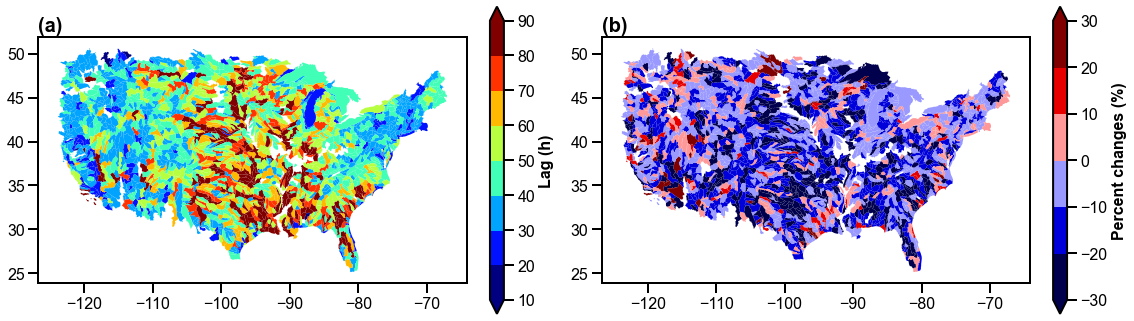

In [468]:
fig= plt.figure(figsize=(16,6))
ax=fig.add_subplot(121)
bounds= np.arange(10,100,10)
cmap= plt.get_cmap('jet',len(bounds)-1)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
huc8.plot(column=huc8.lag_ctl,ax=ax, cmap=cmap, norm=norm, legend=True,
         legend_kwds={'fraction':0.03,'extend':'both', 'label':'Lag (h)'})
ax.set_title('(a)', loc='left', weight='bold')
ax= fig.add_subplot(122)
bounds= np.arange(-30,40,10)
cmap= plt.get_cmap('seismic',len(bounds)-1)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
huc8.plot(column=(huc8.lag_pgw-huc8.lag_ctl)/huc8.lag_ctl*100, ax=ax, cmap=cmap, norm=norm,legend=True,
         legend_kwds={'fraction':0.03,'extend':'both', 'label':'Percent changes (%)'})
ax.set_title('(b)', loc='left', weight='bold');

# Causation factors - rainfall duration, peak rainfall, and event rainfall

In [36]:
huc8= huc8.drop_duplicates('TNMID')

In [122]:
for ind in df_intersect.index.tolist():
    huc8.loc[ind, 'Rp_ctl']= np.nanquantile(df_intersect.loc[ind,'Rp_ctl'], 0.99)
    huc8.loc[ind, 'Rp_pgw']= np.nanquantile(df_intersect.loc[ind,'Rp_pgw'], 0.99)

In [37]:
duration_ctl= []#rainfall duration
rr_ctl = []#rainfall rate
er_ctl = []#event rainfall
flashiness_ctl= []
df_intersect= pd.DataFrame(columns=['Dr_ctl','Dr_pgw', 'Df_ctl', 'Df_pgw','Rp_ctl', 'Rp_pgw','Vr_ctl', 'Vr_pgw','Qp_ctl',
                                    'Qp_pgw','Vf_ctl','Vf_pgw','lag_ctl', 'lag_pgw', 'flashiness_ctl', 'flashiness_pgw', 'climate'])
prev= 0
for col in huc8.index.tolist():
    if os.path.exists('GSCD/ctl/Results%d.mat'%(int(col)+1)) and os.path.exists('GSCD/pgw/Results%d.mat'%(int(col)+1)):
        ctl= io.loadmat('GSCD/ctl/Results%d.mat'%(int(col)+1))
        pgw= io.loadmat('GSCD/pgw/Results%d.mat'%(int(col)+1))
        Trs_ctl= ctl['RFE']['tE'][0,0][:,0]
        Tre_ctl= ctl['RFE']['tE'][0,0][:,2]
        Dr_ctl= ctl['RFE']['D'][0,0][:,0]
        Df_ctl= ctl['RFE']['D'][0,0][:,1]        
        lag_ctl= ctl['RFE']['D'][0,0][:,-1]
        Tp_ctl= ctl['RFE']['tE'][0,0][:,-1].astype(int)
        Ts_ctl= ctl['RFE']['tE'][0,0][:,1].astype(int)
        Te_ctl= ctl['RFE']['tE'][0,0][:,3].astype(int)
        Qp_ctl= ctl['Q'] - ctl['Qbf']
        P_ctl = ctl['P']
        qp_ctl= ctl['Q'][Tp_ctl] - ctl['Qbf'][Tp_ctl]
        _flashiness_ctl= qp_ctl.reshape(-1)/(Tp_ctl-Ts_ctl)
        Tp_pgw= pgw['RFE']['tE'][0,0][:,-1].astype(int)
        Ts_pgw= pgw['RFE']['tE'][0,0][:,1].astype(int)
        Te_pgw= pgw['RFE']['tE'][0,0][:,3].astype(int)        
        Dr_pgw= pgw['RFE']['D'][0,0][:,0]
        Df_pgw= pgw['RFE']['D'][0,0][:,1]        
        lag_pgw= pgw['RFE']['D'][0,0][:,-1]
        Trs_pgw= pgw['RFE']['tE'][0,0][:,0]
        Tre_pgw= pgw['RFE']['tE'][0,0][:,2]
        Qp_pgw= pgw['Q'] - pgw['Qbf']
        qp_pgw= pgw['Q'][Tp_pgw] - pgw['Qbf'][Tp_pgw]
        P_pgw= pgw['P']
        _flashiness_pgw= qp_pgw.reshape(-1)/(Tp_pgw-Ts_pgw)
        if len(_flashiness_ctl)>0:
            iday=5
            flashiness_ctl= dist(_flashiness_ctl)
            flashiness_pgw= dist(_flashiness_pgw)
            #dynamic programming to find common events
            while len(Ts_ctl)!=len(Ts_pgw):
                if min(len(Ts_ctl), len(Ts_pgw))==0:
                    break
                isinCTL= [True if np.min(abs(Ts_ctl-t))<iday*24 else False for t in Ts_pgw]
                isinPGW= [True if np.min(abs(Ts_pgw-t))<iday*24 else False for t in Ts_ctl]
                Ts_ctl= Ts_ctl[isinPGW]
                Te_ctl= Te_ctl[isinPGW]
                Trs_ctl= Trs_ctl[isinPGW]
                Tre_ctl= Tre_ctl[isinPGW]
                Ts_pgw= Ts_pgw[isinCTL]
                Te_pgw= Te_pgw[isinCTL]
                Trs_pgw= Trs_pgw[isinCTL]
                Tre_pgw= Tre_pgw[isinCTL]
                flashiness_ctl= flashiness_ctl[isinPGW]
                flashiness_pgw= flashiness_pgw[isinCTL]
                Dr_pgw=Dr_pgw[isinCTL]
                Df_pgw=Df_pgw[isinCTL]
                lag_pgw= lag_pgw[isinCTL]
                Dr_ctl=Dr_ctl[isinPGW]
                Df_ctl=Df_ctl[isinPGW]
                lag_ctl= lag_ctl[isinPGW]
                iday-=1

            if min(len(Ts_ctl), len(Ts_pgw))!=0:
                assert len(Trs_ctl)==len(Trs_pgw), 'length CTL %d, but length PGW %d'%(len(Trs_ctl), len(Trs_pgw))
                _P_ctl= np.array([np.nanmax(P_ctl[int(start):int(end)]) for (start,end) in zip(Trs_ctl, Tre_ctl)])
                _P_pgw= np.array([np.nanmax(P_pgw[int(start):int(end)]) for (start,end) in zip(Trs_pgw, Tre_pgw)])
                _Qp_ctl= np.array([np.nanmax(Qp_ctl[int(start):int(end)]) for (start,end) in zip(Ts_ctl, Te_ctl)])
                _Qp_pgw= np.array([np.nanmax(Qp_pgw[int(start):int(end)]) for (start,end) in zip(Ts_pgw, Te_pgw)])                
                _Vr_ctl= np.array([np.nansum(P_ctl[int(start):int(end)]) for (start,end) in zip(Trs_ctl, Tre_ctl)])
                _Vr_pgw= np.array([np.nansum(P_pgw[int(start):int(end)]) for (start,end) in zip(Trs_pgw, Tre_pgw)])
                _Vf_ctl= np.array([np.nansum(Qp_ctl[int(start):int(end)]) for (start,end) in zip(Ts_ctl, Te_ctl)])
                _Vf_pgw= np.array([np.nansum(Qp_pgw[int(start):int(end)]) for (start,end) in zip(Ts_pgw, Te_pgw)])
                

                df_intersect.loc[col, 'Dr_ctl']= Dr_ctl
                df_intersect.loc[col, 'Dr_pgw']= Dr_pgw
                df_intersect.loc[col, 'Df_ctl']= Df_ctl
                df_intersect.loc[col, 'Df_pgw']= Df_pgw
                df_intersect.loc[col, 'Rp_ctl']= _P_ctl
                df_intersect.loc[col, 'Rp_pgw']= _P_pgw
                df_intersect.loc[col, 'Vr_ctl']= _Vr_ctl                
                df_intersect.loc[col, 'Vr_pgw']= _Vr_pgw
                df_intersect.loc[col, 'Vf_ctl']= _Vf_ctl
                df_intersect.loc[col, 'Vf_pgw']= _Vf_pgw
                df_intersect.loc[col, 'Qp_ctl']= _Qp_ctl                
                df_intersect.loc[col, 'Qp_pgw']= _Qp_pgw
                
                df_intersect.loc[col, 'lag_ctl']= lag_ctl                
                df_intersect.loc[col, 'lag_pgw']= lag_pgw
                df_intersect.loc[col, 'flashiness_ctl']= flashiness_ctl                
                df_intersect.loc[col, 'flashiness_pgw']= flashiness_pgw 
                df_intersect.loc[col, 'climate']= huc8.loc[col, 'label'] 
#                 df_intersect.loc[col, 'huc8_ind']= col
#                 flashiness.append(flashiness_pgw-flashiness_ctl)
#                 duration.append(Dr_pgw-Dr_ctl)
#                 rr.append(_rr_pgw-_rr_ctl)
#                 er.append(_er_pgw-_er_ctl)
        else:
            pass
        
        

In [48]:
_df= pd.DataFrame()
for col in df_intersect.columns:
    if col!='climate':
        _df[col]= np.concatenate(df_intersect[col].values)
    else:
        _df['climate']= np.concatenate([[df_intersect.iloc[i,-1]] * len(df_intersect.iloc[i,1]) for i in range(len(df_intersect))])

In [52]:
climate_zone['label']= climate_zone.Region.map(encode)

In [54]:
climate_zone.set_index('label', inplace=True)

In [63]:
# assign characteristics to climate zone gdf
climate_zone['size']= _df.groupby('climate').size()
col='Dr'
climate_zone['+%s'%col]= _df.groupby('climate').agg(lambda x: (x['%s_pgw'%col]-x['%s_ctl'%col]>0).sum())['%s_ctl'%col]
climate_zone['-%s'%col]= _df.groupby('climate').agg(lambda x: (x['%s_pgw'%col]-x['%s_ctl'%col]<0).sum())['%s_ctl'%col]
col='Df'
climate_zone['+%s'%col]= _df.groupby('climate').agg(lambda x: (x['%s_pgw'%col]-x['%s_ctl'%col]>0).sum())['%s_ctl'%col]
climate_zone['-%s'%col]= _df.groupby('climate').agg(lambda x: (x['%s_pgw'%col]-x['%s_ctl'%col]<0).sum())['%s_ctl'%col]
col='Rp'
climate_zone['+%s'%col]= _df.groupby('climate').agg(lambda x: (x['%s_pgw'%col]-x['%s_ctl'%col]>0).sum())['%s_ctl'%col]
climate_zone['-%s'%col]= _df.groupby('climate').agg(lambda x: (x['%s_pgw'%col]-x['%s_ctl'%col]<0).sum())['%s_ctl'%col]
col='Qp'
climate_zone['+%s'%col]= _df.groupby('climate').agg(lambda x: (x['%s_pgw'%col]-x['%s_ctl'%col]>0).sum())['%s_ctl'%col]
climate_zone['-%s'%col]= _df.groupby('climate').agg(lambda x: (x['%s_pgw'%col]-x['%s_ctl'%col]<0).sum())['%s_ctl'%col]
col='Vr'
climate_zone['+%s'%col]= _df.groupby('climate').agg(lambda x: (x['%s_pgw'%col]-x['%s_ctl'%col]>0).sum())['%s_ctl'%col]
climate_zone['-%s'%col]= _df.groupby('climate').agg(lambda x: (x['%s_pgw'%col]-x['%s_ctl'%col]<0).sum())['%s_ctl'%col]
col='Vf'
climate_zone['+%s'%col]= _df.groupby('climate').agg(lambda x: (x['%s_pgw'%col]-x['%s_ctl'%col]>0).sum())['%s_ctl'%col]
climate_zone['-%s'%col]= _df.groupby('climate').agg(lambda x: (x['%s_pgw'%col]-x['%s_ctl'%col]<0).sum())['%s_ctl'%col]
col='lag'
climate_zone['+%s'%col]= _df.groupby('climate').agg(lambda x: (x['%s_pgw'%col]-x['%s_ctl'%col]>0).sum())['%s_ctl'%col]
climate_zone['-%s'%col]= _df.groupby('climate').agg(lambda x: (x['%s_pgw'%col]-x['%s_ctl'%col]<0).sum())['%s_ctl'%col]

col='flashiness'
climate_zone['+%s'%col]= _df.groupby('climate').agg(lambda x: (x['%s_pgw'%col]-x['%s_ctl'%col]>0).sum())['%s_ctl'%col]
climate_zone['-%s'%col]= _df.groupby('climate').agg(lambda x: (x['%s_pgw'%col]-x['%s_ctl'%col]<0).sum())['%s_ctl'%col]

In [65]:
climate_zone.to_file('BukovskyRegion/zone_stats_0526')

In [21]:
melted= _df.melt()
melted['x']= [var.split('_')[0] for var in melted.variable]
melted['hue']= [var.split('_')[1] for var in melted.variable]

In [22]:
melted.hue= melted.hue.str.upper()

In [89]:
from scipy import stats
import matplotlib.patches as patches
import seaborn as sns

In [24]:
p_less= []
p_more= []
for col in melted.x.unique():
    print(col)
    p_less.append(stats.ks_2samp(_df[col+'_ctl'], _df[col+'_pgw'], alternative='less')[1])
    p_more.append(stats.ks_2samp(_df[col+'_ctl'], _df[col+'_pgw'], alternative='greater')[1])

Dr
Df
Rp
Vr
Qp
Vf
lag
flashiness


In [34]:
melted.x.unique()

array(['Dr', 'Df', 'Rp', 'Vr', 'Qp', 'Vf', 'lag', 'flashiness'],
      dtype=object)

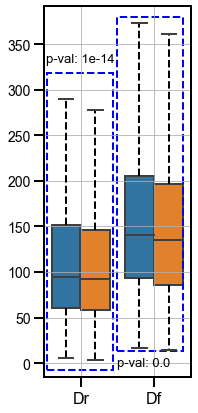

In [113]:
fig=plt.figure(figsize=(3,6))
ax=fig.add_subplot(111)
ax= sns.boxplot(x='x',y='value',hue='hue',data=melted[(melted.x=='Dr') | (melted.x=='Df')],showfliers=False,
                ax=ax,
               whiskerprops=dict(linestyle='--',linewidth=2.0, color='black'))
rect = patches.Rectangle((0.02, 0.02), 0.45, 0.8, linewidth=2, ec='b', fc='none', transform=ax.transAxes, linestyle='dashed')
ax.add_patch(rect)
ax.text(0.01, 0.85,'p-val: 1e-14', transform=ax.transAxes,fontsize=13)

rect = patches.Rectangle((0.5, 0.07), 0.45, 0.9, linewidth=2, ec='b', fc='none', transform=ax.transAxes, linestyle='dashed')
ax.add_patch(rect)
ax.text(0.5, 0.03,'p-val: 0.0', transform=ax.transAxes,fontsize=13)
ax.set_yticklabels(ax.get_yticks().astype(int), fontsize=14)
ax.set_xlabel('')
ax.set_ylabel('')
ax.grid()
ax.get_legend().remove();

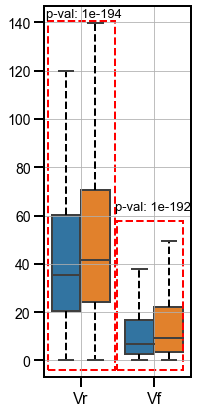

In [114]:
fig=plt.figure(figsize=(3,6))
ax=fig.add_subplot(111)
ax= sns.boxplot(x='x',y='value',hue='hue',data=melted[(melted.x=='Vr') | (melted.x=='Vf')],showfliers=False,
                ax=ax,
               whiskerprops=dict(linestyle='--',linewidth=2.0, color='black'))
rect = patches.Rectangle((0.03, 0.02), 0.45, 0.94, linewidth=2, ec='r', fc='none', transform=ax.transAxes, linestyle='dashed')
ax.add_patch(rect)
ax.text(0.01, 0.97,'p-val: 1e-194', transform=ax.transAxes,fontsize=13)

rect = patches.Rectangle((0.5, 0.02), 0.45, 0.4, linewidth=2, ec='r', fc='none', transform=ax.transAxes, linestyle='dashed')
ax.add_patch(rect)
ax.text(0.48, 0.45,'p-val: 1e-192', transform=ax.transAxes,fontsize=13)
ax.set_yticklabels(ax.get_yticks().astype(int), fontsize=14)
ax.set_xlabel('')
ax.set_ylabel('')
ax.grid()
ax.get_legend().remove();

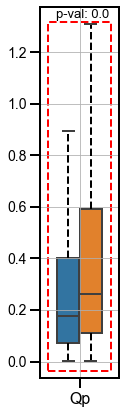

In [120]:
fig=plt.figure(figsize=(2,6))
ax=fig.add_subplot(111)
ax= sns.boxplot(x='x',y='value',hue='hue',data=melted[(melted.x=='Qp')],showfliers=False,
                ax=ax,
               whiskerprops=dict(linestyle='--',linewidth=2.0, color='black'))
rect = patches.Rectangle((0.1, 0.02), 0.8, 0.94, linewidth=2, ec='r', fc='none', transform=ax.transAxes, linestyle='dashed')
ax.add_patch(rect)
ax.text(0.2, 0.97,'p-val: 0.0', transform=ax.transAxes,fontsize=13)

# rect = patches.Rectangle((0.5, 0.02), 0.45, 0.4, linewidth=2, ec='r', fc='none', transform=ax.transAxes, linestyle='dashed')
# ax.add_patch(rect)
# ax.text(0.48, 0.45,'p-val: 1e-192', transform=ax.transAxes,fontsize=13)
ax.set_yticklabels(['%.1f'%val for val in ax.get_yticks()], fontsize=14)
ax.set_xlabel('')
ax.set_ylabel('')
ax.grid()
ax.get_legend().remove();

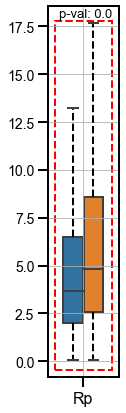

In [121]:
fig=plt.figure(figsize=(2,6))
ax=fig.add_subplot(111)
ax= sns.boxplot(x='x',y='value',hue='hue',data=melted[(melted.x=='Rp')],showfliers=False,
                ax=ax,
               whiskerprops=dict(linestyle='--',linewidth=2.0, color='black'))
rect = patches.Rectangle((0.1, 0.02), 0.8, 0.94, linewidth=2, ec='r', fc='none', transform=ax.transAxes, linestyle='dashed')
ax.add_patch(rect)
ax.text(0.15, 0.97,'p-val: 0.0', transform=ax.transAxes,fontsize=13)

# rect = patches.Rectangle((0.5, 0.02), 0.45, 0.4, linewidth=2, ec='r', fc='none', transform=ax.transAxes, linestyle='dashed')
# ax.add_patch(rect)
# ax.text(0.48, 0.45,'p-val: 1e-192', transform=ax.transAxes,fontsize=13)
ax.set_yticklabels(['%.1f'%val for val in ax.get_yticks()], fontsize=14)
ax.set_xlabel('')
ax.set_ylabel('')
ax.grid()
ax.get_legend().remove();

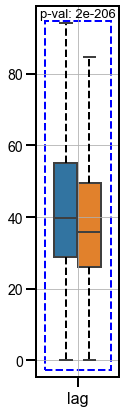

In [123]:
fig=plt.figure(figsize=(2,6))
ax=fig.add_subplot(111)
ax= sns.boxplot(x='x',y='value',hue='hue',data=melted[(melted.x=='lag')],showfliers=False,
                ax=ax,
               whiskerprops=dict(linestyle='--',linewidth=2.0, color='black'))
rect = patches.Rectangle((0.1, 0.02), 0.8, 0.94, linewidth=2, ec='b', fc='none', transform=ax.transAxes, linestyle='dashed')
ax.add_patch(rect)
ax.text(0.05, 0.97,'p-val: 2e-206', transform=ax.transAxes,fontsize=13)

# rect = patches.Rectangle((0.5, 0.02), 0.45, 0.4, linewidth=2, ec='r', fc='none', transform=ax.transAxes, linestyle='dashed')
# ax.add_patch(rect)
# ax.text(0.48, 0.45,'p-val: 1e-192', transform=ax.transAxes,fontsize=13)
ax.set_yticklabels(['%d'%val for val in ax.get_yticks()], fontsize=14)
ax.set_xlabel('')
ax.set_ylabel('')
ax.grid()
ax.get_legend().remove();

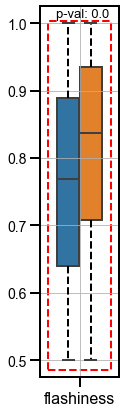

In [127]:
fig=plt.figure(figsize=(2,6))
ax=fig.add_subplot(111)
ax= sns.boxplot(x='x',y='value',hue='hue',data=melted[(melted.x=='flashiness')],showfliers=False,
                ax=ax,
               whiskerprops=dict(linestyle='--',linewidth=2.0, color='black'))
rect = patches.Rectangle((0.1, 0.02), 0.8, 0.94, linewidth=2, ec='r', fc='none', transform=ax.transAxes, linestyle='dashed')
ax.add_patch(rect)
ax.text(0.2, 0.97,'p-val: 0.0', transform=ax.transAxes,fontsize=13)

# rect = patches.Rectangle((0.5, 0.02), 0.45, 0.4, linewidth=2, ec='r', fc='none', transform=ax.transAxes, linestyle='dashed')
# ax.add_patch(rect)
# ax.text(0.48, 0.45,'p-val: 1e-192', transform=ax.transAxes,fontsize=13)
ax.set_yticklabels(['%.1f'%val for val in ax.get_yticks()], fontsize=14)
ax.set_xlabel('')
ax.set_ylabel('')
ax.grid()
ax.get_legend().remove();

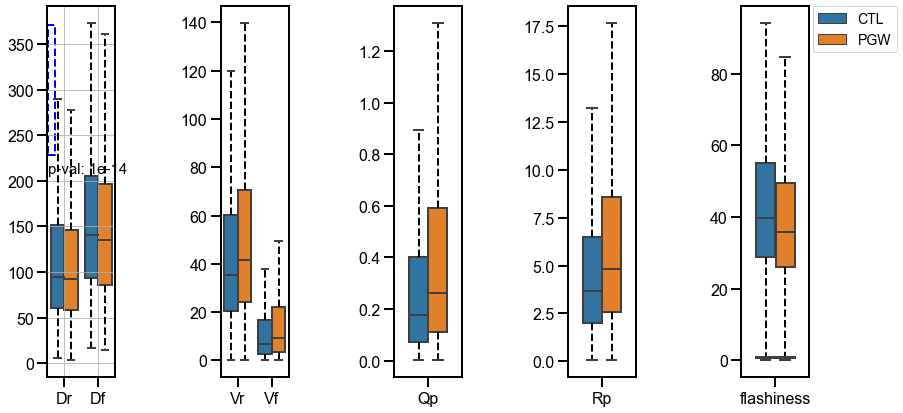

In [58]:
fig=plt.figure(figsize=(14,6))
ax=fig.add_subplot(161)
ax= sns.boxplot(x='x',y='value',hue='hue',data=melted[(melted.x=='Dr') | (melted.x=='Df')],showfliers=False,
                ax=ax,
               whiskerprops=dict(linestyle='--',linewidth=2.0, color='black'))
# ax.set_yscale('log')
ax.set_xlabel('')
ax.set_ylabel('')
ax.get_legend().remove()
ax.grid()
rect = patches.Rectangle((0.01, 0.6), 0.11, 0.35, linewidth=2, ec='b', fc='none', transform=ax.transAxes, linestyle='dashed')
ax.add_patch(rect)
ax.text(0.01, 0.55,'p-val: 1e-14', transform=ax.transAxes)

ax=fig.add_subplot(162)
ax= sns.boxplot(x='x',y='value',hue='hue',data=melted[(melted.x=='Vr') | (melted.x=='Vf')],showfliers=False,
                ax=ax,
               whiskerprops=dict(linestyle='--',linewidth=2.0, color='black'))
ax.set_xlabel('')
ax.set_ylabel('')
ax.get_legend().remove()

ax=fig.add_subplot(163)
ax= sns.boxplot(x='x',y='value',hue='hue',data=melted[(melted.x=='Qp')],showfliers=False,
                ax=ax,
               whiskerprops=dict(linestyle='--',linewidth=2.0, color='black'))
ax.set_xlabel('')
ax.set_ylabel('')
ax.get_legend().remove()

ax=fig.add_subplot(164)
ax= sns.boxplot(x='x',y='value',hue='hue',data=melted[(melted.x=='Rp')],showfliers=False,
                ax=ax,
               whiskerprops=dict(linestyle='--',linewidth=2.0, color='black'))
ax.set_xlabel('')
ax.set_ylabel('')
ax.get_legend().remove()

ax=fig.add_subplot(165)
ax= sns.boxplot(x='x',y='value',hue='hue',data=melted[(melted.x=='lag')],showfliers=False,
                ax=ax,
               whiskerprops=dict(linestyle='--',linewidth=2.0, color='black'))
ax.set_xlabel('')
ax.set_ylabel('')
ax.get_legend().remove()

ax=fig.add_subplot(165)
ax= sns.boxplot(x='x',y='value',hue='hue',data=melted[(melted.x=='flashiness')],showfliers=False,
                ax=ax,
               whiskerprops=dict(linestyle='--',linewidth=2.0, color='black'))
ax.set_xlabel('')
ax.set_ylabel('')

handles, labels = ax.get_legend_handles_labels()

l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
# rect = patches.Rectangle((0.131, 0.7), 0.11, 0.27, linewidth=2, ec='b', fc='none', transform=ax.transAxes, linestyle='dashed')
# ax.add_patch(rect)
# ax.text( 0.135, 0.65,'p-val: 7e-32', transform=ax.transAxes)

# rect = patches.Rectangle((0.256, 0.32), 0.11, 0.45, linewidth=2, ec='r', fc='none', transform=ax.transAxes, linestyle='dashed')
# ax.add_patch(rect)
# ax.text( 0.265, 0.28,'p-val: 0.0', transform=ax.transAxes)

# rect = patches.Rectangle((0.385, 0.05), 0.11, 0.6, linewidth=2, ec='r', fc='none', transform=ax.transAxes, linestyle='dashed')
# ax.add_patch(rect)
# ax.text( 0.38, 0.01,'p-val: 6e-194', transform=ax.transAxes)

# rect = patches.Rectangle((0.505, 0.40), 0.11, 0.5, linewidth=2, ec='r', fc='none', transform=ax.transAxes, linestyle='dashed')
# ax.add_patch(rect)
# ax.text( 0.52, 0.35,'p-val: 0.0', transform=ax.transAxes)

# rect = patches.Rectangle((0.633, 0.2), 0.11, 0.65, linewidth=2, ec='r', fc='none', transform=ax.transAxes, linestyle='dashed')
# ax.add_patch(rect)
# ax.text( 0.63, 0.16,'p-val: 1e-192', transform=ax.transAxes);

# rect = patches.Rectangle((0.76, 0.2), 0.11, 0.7, linewidth=2, ec='b', fc='none', transform=ax.transAxes, linestyle='dashed')
# ax.add_patch(rect)
# ax.text( 0.76, 0.16,'p-val: 2e-206', transform=ax.transAxes);

# rect = patches.Rectangle((0.883, 0.5), 0.11, 0.1, linewidth=2, ec='r', fc='none', transform=ax.transAxes, linestyle='dashed')
# ax.add_patch(rect)
# ax.text( 0.89, 0.45,'p-val: 0.0', transform=ax.transAxes);

In [363]:
duration= np.concatenate(duration)
rr= np.concatenate(rr)
flashiness= np.concatenate(flashiness)
er= np.concatenate(er)

In [374]:
masks= (rr<np.quantile(rr,0.95)) & (rr>np.quantile(rr,0.05))

In [ ]:
data= pd.DataFrame()
data['ref']= (_df.flashiness_pgw - _df.flashiness_ctl)/_df.flashiness_ctl*100
data['x']= (_df.Rp_pgw - _df.Rp_ctl)/_df.Rp_ctl*100
fig=plt.figure(figsize=(12,6))
ax=fig.add_subplot(111)

data['value_group']= pd.cut(data.x, np.arange(-40,220,20))
sns.boxplot(data=data,x ='x', y='ref',ax=ax, showfliers=False)
ax.set_xlabel('Max. rainfall rates differences (mm/h)')
ax.set_ylabel('Flashiness')
# ax.
ax.set_xticklabels(ax.get_xticklabels(),rotation=45);

In [141]:
import pyart


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [196]:
from matplotlib.lines import Line2D

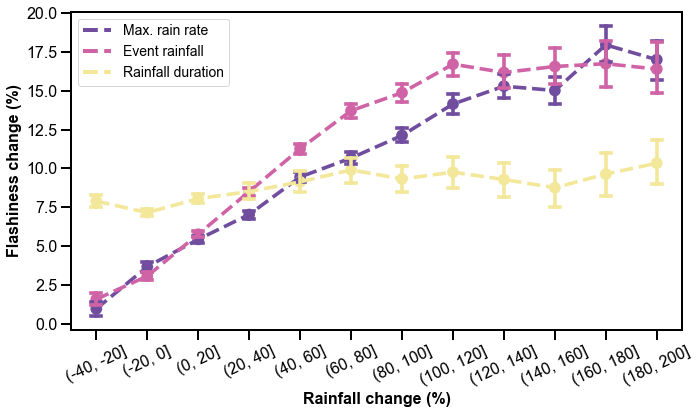

In [478]:
fig=plt.figure(figsize=(10,6))
ax=fig.add_subplot(111)
data= pd.DataFrame()
data['ref']= (_df.flashiness_pgw - _df.flashiness_ctl)/_df.flashiness_ctl*100
data['x']= (_df.Rp_pgw - _df.Rp_ctl)/_df.Rp_ctl*100
data['value_group']= pd.cut(data.x, np.arange(-40,220,20))
sns.pointplot(x='value_group',y='ref',data=data, capsize=.2,ax=ax,color='#704D9E',label='Max. rain rate',linestyles='--')
data= pd.DataFrame()
data['x']= (_df.Vr_pgw - _df.Vr_ctl)/_df.Vr_ctl*100
data['value_group']= pd.cut(data.x, np.arange(-40,220,20))
data['ref']= (_df.flashiness_pgw - _df.flashiness_ctl)/_df.flashiness_ctl*100
sns.pointplot(x='value_group',y='ref',data=data, capsize=.2,ax=ax,color='#CF63A6',label='event rainfall',linestyles='--')

data= pd.DataFrame()
data['x']= (_df.Dr_pgw - _df.Dr_ctl)/_df.Dr_ctl*100
data['value_group']= pd.cut(data.x, np.arange(-40,220,20))
data['ref']= (_df.flashiness_pgw - _df.flashiness_ctl)/_df.flashiness_ctl*100
sns.pointplot(x='value_group',y='ref',data=data, capsize=.2,ax=ax,color='#F3E79A',label='Rainfall duration',linestyles='--')



plt.legend(handles=[Line2D([0], [0], color='#704D9E', lw=4, linestyle='--'),
                   Line2D([0], [0], color='#CF63A6', lw=4, linestyle='--'),
                   Line2D([0], [0], color='#F3E79A', lw=4, linestyle='--')],labels=["Max. rain rate","Event rainfall","Rainfall duration"])
# ax.grid()
# ax.vlines(1,0,20,color='r',linestyle='--')
ax.set_xticklabels(ax.get_xticklabels(),rotation=25)
ax.set_ylabel('Flashiness change (%)')
ax.set_xlabel('Rainfall change (%)');

In [381]:
from statsmodels.formula.api import ols

# Climate divisions (Bukovsky)

In [7]:
climate_zone= gpd.read_file('BukovskyRegion/BukovskyRegion.geojson')

In [7]:
huc8= gpd.sjoin(huc8, climate_zone[['Region', 'geometry']], how='left', op='intersects')

In [39]:
lccProjParams = { 'central_latitude'   : 50.0, # same as lat_0 in proj4 string 
                  'central_longitude'  : -96.0, # same as lon_0
                  'standard_parallels' : (33.0, 45.0) # same as (lat_1, lat_2)
}
proj = ccrs.LambertConformal(**lccProjParams)

In [85]:
dem= dem.rio.write_crs(4326)
dem= dem.rio.clip([dissolved.geometry[1]])
dem_vals= dem.values.squeeze()
dem_vals[dem_vals==-9999.0]= np.nan

In [68]:
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER

In [79]:
dissolved= climate_zone.dissolve(by='fid')

/home/ZhiLi/env/lib/python3.6/site-packages/geopandas/plotting.py:433: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.draw()
/home/ZhiLi/env/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ZhiLi/env/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


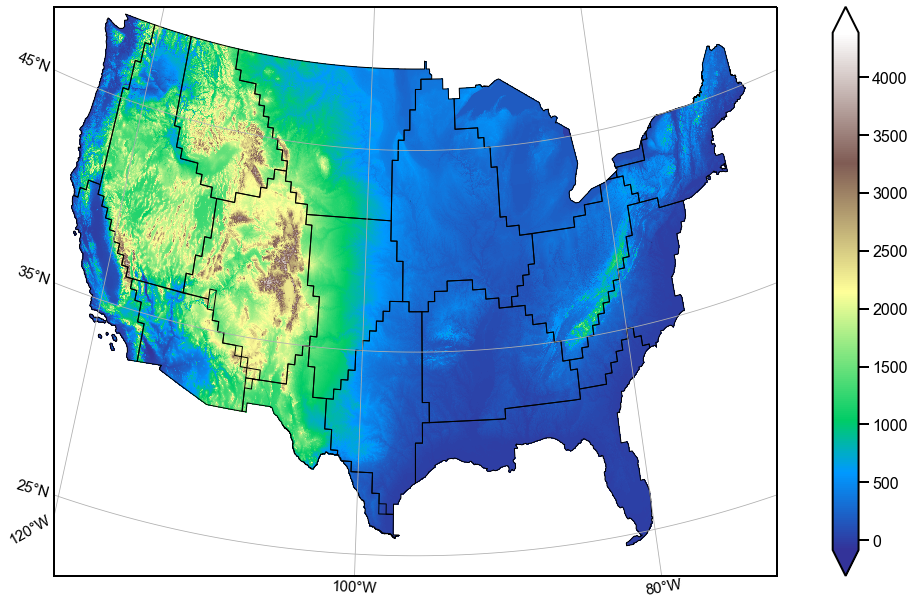

In [88]:
fig=plt.figure(figsize=(16,9))
ax=fig.add_subplot(projection=proj)
cs= ax.pcolormesh(dem.x,dem.y,dem_vals,cmap='terrain', transform=ccrs.PlateCarree())
climate_zone.plot(transform=ccrs.PlateCarree(),ax=ax, color='None', edgecolor='k')
fig.colorbar(extend='both', mappable=cs)
ax.set_extent([-120.0, -72.0, 24.0, 50.0], crs=ccrs.PlateCarree())
xticks = np.arange(-120,-72,20)
yticks = np.arange(25,55,10)
gl= ax.gridlines(xlocs=xticks, ylocs=yticks, draw_labels=True,dms=False,
                      x_inline=False,
                      y_inline=False)
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
gl.xlabel_style = {'size': 15, 'color': 'black'}  # control how the tick labels look
gl.ylabel_style = {'size': 15, 'color': 'black'}
import matplotlib.ticker as mticker
gl.xlabels_top = False 
gl.ylabels_right = False;
# gl.xlocator = mticker.FixedLocator([-105, -95, -85, -75, -65]);

In [90]:
import seaborn as sns

In [107]:
huc8['percent_change']= (huc8.flashiness_pgw-huc8.flashiness_ctl)/huc8.flashiness_ctl*100

In [12]:
encode= {'SouthernRockies':'h', 'Mezquital':'f','CentralPlain':'i','Southwest':'e','GreatBasin':'c','SouthPlain':'g',
        'Prairie':'k','PacificSouthWest':'a','MidAtlantic':'n', 'Appalachia':'p', 'Southeast':'m','DeepSouth':'o',
        'NorthPlain':'j', 'PacificNorthWest':'b','NorthernRockies':'d','NorthAtlantic':'q','GreatLakes':'l'}
dict_colors={'SouthernRockies':np.array([203,109,54])/255.,
                 'Mezquital':np.array([255,246,140])/255.,
                 'CentralPlain':np.array([238,123,165])/255.,
                 'Southwest':np.array([245,181,85])/255.,
                 'GreatBasin':np.array([127,94,43])/255.,
                 'SouthPlain':np.array([245,191,212])/255.,
                'Prairie':np.array([158,32,66])/255.,
                 'PacificSouthWest':np.array([157,42,196])/255.,
                 'MidAtlantic':np.array([162,237,141])/255.,
                 'Appalachia':np.array([39,92,30])/255.,
                 'Southeast':np.array([113,244,208])/255.,
                 'DeepSouth':np.array([70,158,162])/255.,
                 'NorthPlain':np.array([234,62,116])/255.,
                'PacificNorthWest':np.array([87,32,195])/255.,
                 'NorthernRockies':np.array([137,75,78])/255.,
                 'NorthAtlantic':np.array([86,164,62])/255.,
                 'GreatLakes':np.array([25,22,166])/255.}

In [16]:
huc8['label']= huc8.Region_left.map(encode)

In [148]:
huc8['colors']= huc8.Region.map(dict_colors)

In [174]:
climate_zone['label']= climate_zone.Region.map(encode)

/home/ZhiLi/env/lib/python3.6/site-packages/geopandas/plotting.py:573: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning


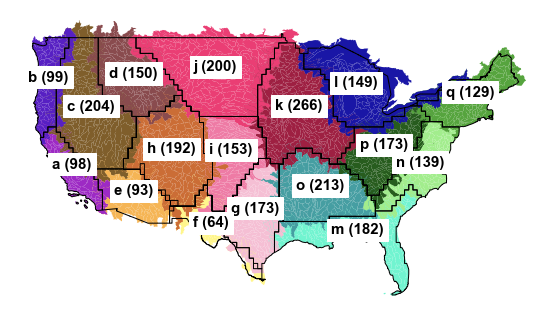

In [112]:
fig=plt.figure(figsize=(8,6))
ax=fig.add_subplot(111)
# cmap= matplotlib.colors.ListedColormap(huc8[~pd.isna(huc8.Region)].colors)
basin_nums= huc8.groupby('Region').size()
huc8[~pd.isna(huc8.Region)].plot('Region',color=huc8[~pd.isna(huc8.Region)].colors,ax=ax)
climate_zone.plot(ax=ax, color='None', edgecolor='k')
ax.axis('off');

for idx, row in climate_zone.iterrows():
    num=basin_nums[row['Region']]
    ax.annotate(s='%s (%d)'%(row['label'], num), xy=np.array(row.geometry.centroid.coords).squeeze(),
                 horizontalalignment='center', color='k', weight='bold', backgroundcolor="w")
plt.show();

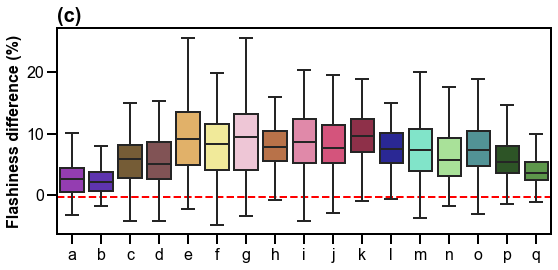

In [107]:
orders= ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q']
fig= plt.figure(figsize=(8,4))
ax= fig.add_subplot(111)
ax= sns.boxplot(x=huc8.Region.map(encode), y=(huc8.flashine_3-huc8.flashine_2)/huc8.flashine_2*100,notch=False,
                showfliers=False,ax=ax,order=orders,
                palette=[huc8[huc8.Region.map(encode)==o].colors.values[0] for o in orders])
ax.hlines(0.18,0,1,transform=ax.transAxes, color='r', linestyle='dashed')
ax.set_title('(c)', weight='bold',loc='left')
ax.set_xlabel('')
ax.set_ylabel('Flashiness difference (%)');
# ticks= ax.get_xticks()
# ax.set_xticks(ticks);
# ax.set_xticklabels(['']);

# Climate Divisions (Koppen)

In [448]:
KG= xr.open_rasterio('Koppen-Geiger/Beck_KG_V1_present_0p0083.tif').\
    sel(x=slice(-126,-60),y=slice(50,20))

In [449]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [455]:
def get_climate(feature):
    global KG    
#     try:
    if np.isnan(feature.climate_code):
        val,cnts= np.unique(KG.rio.clip([feature.geometry]).values, return_counts=True)
#         print(val,cnts)
        cnts= cnts[~np.isnan(val) & (val!=0)]
        val= val[~np.isnan(val)& (val!=0)]
        return val[np.argmax(cnts)]
    else: return feature.climate_code
#     except Exception: return np.nan


In [457]:
huc8['climate_code']= np.nan

In [451]:
huc8['climate_code']= huc8.apply(get_climate, axis=1)

In [ ]:
dissolved['climate_code']= dissolved.index.map(label_to_code)

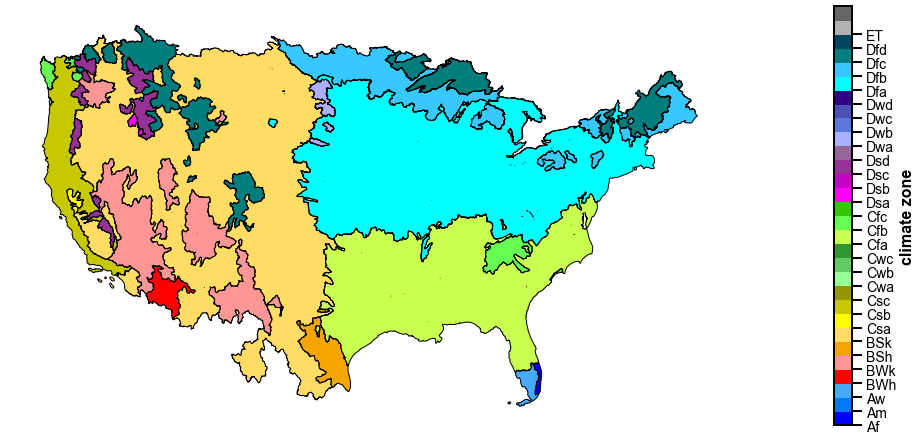

In [604]:
cmap= matplotlib.colors.ListedColormap(np.array(colors)/255.)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
fig=plt.figure()
ax=fig.add_subplot(111)
dissolved.plot(column='climate_code', legend=False, cmap=cmap, norm=norm,ax=ax,edgecolor='k')
ax.axis('off')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
cb= fig.colorbar(orientation='vertical',mappable=sm,cax=cax, ticks= np.arange(0,30,1), fraction=0.7)
cb.set_label('climate zone')
cb.ax.set_yticklabels(['Af','Am','Aw','BWh','BWk','BSh','BSk','Csa','Csb','Csc',
                        'Cwa','Cwb','Cwc','Cfa','Cfb','Cfc','Dsa','Dsb','Dsc','Dsd',
                        'Dwa','Dwb','Dwc','Dwd','Dfa','Dfb','Dfc','Dfd','ET','EF'], fontsize=14, rotation=0);

In [ ]:
fig=plt.figure()
ax=fig.add_subplot(111)
colors= [(0,0,255), (0,120,255), (70,170,250), (255,0,0),
        (255,150,150), (245,165,0),(255,220,100),(255,255,0),
        (200,200,0), (150,150,0),(150,255,150), [100, 200, 100],
        [50, 150, 50],[200, 255, 80], [100, 255, 80],[50, 200, 0],
        [255, 0, 255], [200, 0, 200], [150, 50, 150], [150, 100, 150],
        [170, 175, 255], [90, 120, 220],[75, 80, 180],[50, 0, 135],
        [0, 255, 255],[55, 200, 255],[0, 125, 125],[0, 70, 95],
        [178, 178, 178],[102, 102, 102]]
bounds=np.arange(1,32,1)

cmap= matplotlib.colors.ListedColormap(np.array(colors)/255.)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
huc8.plot(column='climate_code', legend=False, cmap=cmap, norm=norm,ax=ax,edgecolor='k')
ax.axis('off')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=cs.norm)
sm._A = []
cb= fig.colorbar(orientation='vertical',mappable=sm,cax=cax, ticks= np.arange(0,30,1), fraction=0.7)
cb.set_label('climate zone')
cb.ax.set_yticklabels(['Af','Am','Aw','BWh','BWk','BSh','BSk','Csa','Csb','Csc',
                        'Cwa','Cwb','Cwc','Cfa','Cfb','Cfc','Dsa','Dsb','Dsc','Dsd',
                        'Dwa','Dwb','Dwc','Dwd','Dfa','Dfb','Dfc','Dfd','ET','EF'], fontsize=14, rotation=0);

In [599]:
code_to_label= {1:'Af',2:'Am',3:'Aw',4:'BWh',5:'BWk',6:'BSh',7:'BSk',8:'Csa',9:'Csb',10:'Csc',11:'Cwa',12:'Cwb',
               13:'Cwc',14:'Cfa',15:'Cfb',16:'Cfc',17:'Dsa',18:'Dsb',19:'Dsc',20:'Dsd',21:'Dwa',22:'Dwb',
               23:'Dwc',24:'Dwd',25:'Dfa',26:'Dfb',27:'Dfc',28:'Dfd',29:'ET',30:'EF'}

label_to_code= {v:k for (k,v) in code_to_label.items()}

In [496]:
huc8['climate_zone']= huc8.climate_code.map(code_to_label)

In [521]:
huc8['flashiness_diff']= huc8.flashiness_pgw - huc8.flashiness_ctl

In [524]:
huc8[masks].groupby('climate_zone')['flashiness_diff'].median().sort_values()

climate_zone
Csb    0.018489
Dsc    0.020831
Cfb    0.026151
Dfc    0.030456
BSh    0.039179
Dfb    0.045417
BWk    0.047666
BSk    0.050244
Cfa    0.054442
Dfa    0.056190
BWh    0.137379
Name: flashiness_diff, dtype: float64

In [526]:
np.array(colors).shape

(30, 3)

Text(0, 0.5, 'Flashiness difference (%)')

Text(0.5, 0, '')

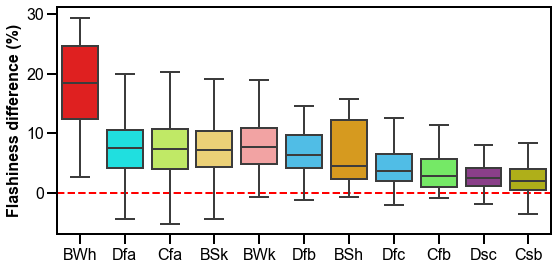

In [627]:
fig=plt.figure(figsize=(8,4))
ax=fig.add_subplot(111)
palette= np.array(colors)[[]]/ 255.
masks= [False if code in [1,17,8,3,21, np.nan, np.inf] or np.isnan(code) else True for code in huc8.climate_code]
ax= sns.boxplot(x=huc8[masks].climate_zone, y=(huc8[masks].flashiness_pgw-huc8[masks].flashiness_ctl)/huc8[masks].flashiness_ctl*100,notch=False,
                showfliers=False, order=['BWh','Dfa','Cfa','BSk','BWk','Dfb','BSh','Dfc','Cfb','Dsc','Csb'],
                palette=np.array(colors)[[3,24,13,6,4,25,5,25,14,18,8]]/255,ax=ax)
ax.hlines(0.18,0,1,transform=ax.transAxes, color='r', linestyle='dashed')
ax.set_ylabel('Flashiness difference (%)')
ax.set_xlabel('')
# ax.set_ylim([-0.05,0.25])
# ax.set_xticklabels(['BWh','BWk','BSh','BSk','Csb','Cfa','Cfb','Dsc',])